In [1]:
# System
import os
import sys
import logging
import multiprocessing as mp
from functools import partial
from collections import Counter

# Externals
import yaml
import pickle
import numpy as np
import pandas as pd
import trackml.dataset
import time
from torch_geometric.data import Data

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    """Computes pseudorapidity
       (https://en.wikipedia.org/wiki/Pseudorapidity)
    """
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [2]:
def select_edges(hits1, hits2, layer1, layer2, 
                 phi_slope_max, z0_max, module_map=[]):

    # start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z', 'module_id']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))

    # compute geometric features of the line through each hit pair
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    eta_1 = calc_eta(hit_pairs.r_1, hit_pairs.z_1)
    eta_2 = calc_eta(hit_pairs.r_2, hit_pairs.z_2)
    deta = eta_2 - eta_1
    dR = np.sqrt(deta**2 + dphi**2)
    
    # phi_slope and z0 used to filter spurious edges
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    
    # apply the intersecting line cut 
    intersected_layer = dr.abs() < -1 
    # 0th barrel layer to left EC or right EC
    if (layer1 == 0) and (layer2 == 11 or layer2 == 4): 
        z_coord = 71.56298065185547 * dz/dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)
    # 1st barrel layer to the left EC or right EC
    if (layer1 == 1) and (layer2 == 11 or layer2 == 4): 
        z_coord = 115.37811279296875 * dz / dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)
        
    # mask edges not in the module map
    mid1 = hit_pairs.module_id_1.values
    mid2 = hit_pairs.module_id_2.values
    in_module_map = module_map[mid1, mid2]

    # filter edges according to selection criteria
    good_edge_mask = ((phi_slope.abs() < phi_slope_max) & # geometric
                      (z0.abs() < z0_max) &               # geometric
                      (intersected_layer == False) &      # geometric
                      (in_module_map))                    # data-driven
    
    # store edges (in COO format) and geometric edge features 
    selected_edges = {'edges': hit_pairs[['index_1', 'index_2']][good_edge_mask],
                      'dr': dr[good_edge_mask],    
                      'dphi': dphi[good_edge_mask], 
                      'dz': dz[good_edge_mask],
                      'dR': dR[good_edge_mask]}
    
    return selected_edges 

In [3]:
def check_truth_labels(hits, edges, y, particle_ids):
    """ Corrects for extra edges surviving the barrel intersection
        cut, i.e. for each particle counts the number of extra 
        "transition edges" crossing from a barrel layer to an 
        innermost endcap slayer; the sum is n_incorrect
        - [edges] = n_edges x 2
        - [y] = n_edges
        - [particle_ids] = n_edges
    """
    # layer indices for barrel-to-endcap edges
    barrel_to_endcaps = {(0,4), (1,4), (2,4),    # barrel to l-EC
                         (0,11), (1,11), (2,11)} # barrel to r-EC
    
    # group hits by particle id, get layer indices
    hits_by_particle = hits.groupby('particle_id')
    layers_1 = hits.layer.loc[edges.index_1].values
    layers_2 = hits.layer.loc[edges.index_2].values

    # loop over particle_id, particle_hits, 
    # count extra transition edges as n_incorrect
    n_incorrect = 0
    for p, particle_hits in hits_by_particle:
        particle_hit_ids = particle_hits['hit_id'].values
        
        # grab true segment indices for particle p
        relevant_indices = ((particle_ids==p) & (y==1))
        
        # get layers connected by particle's edges
        particle_l1 = layers_1[relevant_indices]
        particle_l2 = layers_2[relevant_indices]
        layer_pairs = set(zip(particle_l1, particle_l2))
        
        # count the number of transition edges
        transition_edges = layer_pairs.intersection(barrel_to_endcaps)
        if (len(transition_edges) > 1):
            n_incorrect += 1
            
    if (n_incorrect > 0):
        logging.info(f'incorrectly-labeled edges: {n_incorrect}')
    
    return n_incorrect

In [4]:
def construct_graph(hits, layer_pairs, phi_slope_max, z0_max,
                    feature_names, feature_scale, evtid="-1",
                    module_maps={}, s=(-1,-1)):
    """ Loops over hits in layer pairs and extends edges
        between them based on geometric and/or data-driven
        constraints. 
    """
    # loop over layer pairs, assign edges between their hits
    groups = hits.groupby('layer')
    edges, dr, dphi, dz, dR = [], [], [], [], []
    for (layer1, layer2) in layer_pairs:
        module_map = module_maps[(layer1, layer2)]
        try:
            hits1 = groups.get_group(layer1)
            hits2 = groups.get_group(layer2)
        except KeyError as e: # skip if layer is empty
            continue
            
        # assign edges based on geometric and data-driven constraints
        selected_edges = select_edges(hits1, hits2, layer1, layer2,
                                      phi_slope_max, z0_max,  # geometric 
                                      module_map=module_map)  # data-driven
        edges.append(selected_edges['edges'])
        dr.append(selected_edges['dr'])
        dphi.append(selected_edges['dphi'])
        dz.append(selected_edges['dz'])
        dR.append(selected_edges['dR'])
    
    # if edges were reconstructed, concatenate edge 
    # attributes and indices across all layer pairs 
    if len(edges) > 0:
        edges = pd.concat(edges)
        dr, dphi = pd.concat(dr), pd.concat(dphi)
        dz, dR = pd.concat(dz), pd.concat(dR)
    else: # if no edges were reconstructed, return empty graph 
        edges = np.array([])
        dr, dphi = np.array([]), np.array([])
        dz, dR = np.array([]), np.array([])
        x = (hits[feature_names].values / feature_scale).astype(np.float32)
        return {'x': x, 'edge_index': np.array([[],[]]),
                'edge_attr': np.array([[],[],[],[]]), 
                'y': [], 's': s, 'n_incorrect': 0}
    
    # prepare the graph matrices
    n_nodes = hits.shape[0]
    n_edges = edges.shape[0]
    
    # select and scale relevant features
    x = (hits[feature_names].values / feature_scale).astype(np.float32)
    edge_attr = np.stack((dr/feature_scale[0], 
                          dphi/feature_scale[1], 
                          dz/feature_scale[2], 
                          dR))
    y = np.zeros(n_edges, dtype=np.float32)

    # use a series to map hit label-index onto positional-index.
    node_idx = pd.Series(np.arange(n_nodes), index=hits.index)
    edge_start = node_idx.loc[edges.index_1].values
    edge_end = node_idx.loc[edges.index_2].values
    edge_index = np.stack((edge_start, edge_end))

    # fill the edge, particle labels
    # true edges have the same pid, ignore noise (pid=0)
    pid1 = hits.particle_id.loc[edges.index_1].values
    pid2 = hits.particle_id.loc[edges.index_2].values
    y[:] = ((pid1 == pid2) & (pid1>0) & (pid2>0)) 
    n_incorrect = check_truth_labels(hits, edges, y, pid1)
    
    return {'x': x, 'edge_index': edge_index, 'edge_attr': edge_attr, 
            'y': y, 's': s, 'n_incorrect': n_incorrect}

In [5]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, 
                remove_noise=False, remove_duplicates=False):
     
    # Barrel volume and layer ids
    vlids = [(8,2), # 0 
             (8,4), # 1
             (8,6), # 2
             (8,8)] # 3
    if (endcaps): 
        vlids.extend([(7,14), # 4 
                      (7,12), # 5
                      (7,10), # 6
                      (7,8),  # 7
                      (7,6),  # 8
                      (7,4),  # 9
                      (7,2),  # 10
                      (9,2),  # 11
                      (9,4),  # 12
                      (9,6),  # 13
                      (9,8),  # 14
                      (9,10), # 15
                      (9,12), # 16
                      (9,14), # 17
                     ])
    n_det_layers = len(vlids)
    
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    
    # Calculate particle transverse momentum
    particles['pt'] = np.sqrt(particles.px**2 + particles.py**2)
    particles['eta_pt'] = calc_eta(particles.pt, particles.pz)
    
    # True particle selection.
    particles = particles[particles.pt > pt_min]
    truth_noise = truth[['hit_id', 'particle_id']][truth.particle_id==0]
    truth_noise['pt'] = 0
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'pt', 'eta_pt']], on='particle_id'))

    # optionally add noise 
    if (not remove_noise): 
        truth = truth.append(truth_noise)

    # calculate derived hits variables
    hits['r'] = np.sqrt(hits.x**2 + hits.y**2)
    hits['phi'] = np.arctan2(hits.y, hits.x)
    hits['eta'] = calc_eta(hits.r, hits.z)
    
    # select the data columns we need
    hits = (hits[['hit_id', 'r', 'phi', 'eta', 'z', 'layer', 'module_id']]
            .merge(truth[['hit_id', 'particle_id', 'pt', 'eta_pt']], on='hit_id'))
    
    # optionally remove duplicates
    if (remove_duplicates):
        noise_hits = hits[hits.particle_id==0]
        particle_hits = hits[hits.particle_id!=0]
        particle_hits = particle_hits.loc[particle_hits.groupby(['particle_id', 'layer']).r.idxmin()]
        hits = particle_hits.append(noise_hits)
        
    # relabel particle IDs in [1:n_particles]
    particles = particles[particles.particle_id.isin(pd.unique(hits.particle_id))]
    particle_id_map = {p: i+1 for i, p in enumerate(particles['particle_id'].values)}
    particle_id_map[0] = 0
    particles = particles.assign(particle_id=particles['particle_id'].map(particle_id_map))
    hits = hits.assign(particle_id=hits['particle_id'].map(particle_id_map))
    return hits, particles

In [6]:
def get_particle_properties(hits_by_particle, valid_connections, debug=False):
    """ Calculates the following truth quantities per particle:
         - n_track_segs: number of track segments generated
         - reconstructable: true if particle doesn't skip a layer
         - pt: particle transverse momentum [GeV]
         - eta: pseudorapidity w.r.t. transverse and longitudinal momentum
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs, reconstructable = {}, {}
    pt, eta = {}, {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise isn't reconstructable, store 0s
        if (particle_id==0): 
            reconstructable[particle_id] = 0
            pt[particle_id] = 0
            eta[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
            
        # store pt and eta 
        pt[particle_id] = particle_hits.pt.values[0]
        eta[particle_id] = particle_hits.eta_pt.values[0]
        
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits aren't reconstructable
        if (len(layers)==1): 
            reconstructable[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        reconstructable[particle_id] = layer_pairs.issubset(valid_connections)
        
        # total number of track segments produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
        if debug and (particle_id%100==0):
            print('Test Hit Pattern:', layers_hit)
            print(' - layer pairs:', layer_pairs)
            print(' - reconstructable:', reconstructable[particle_id])
            print(' - n_track_segs:', n_track_segs[particle_id])
            print(' - pt', pt[particle_id])
            print(' - eta', eta[particle_id])
        
    return {'pt': pt, 'eta': eta, 'n_track_segs': n_track_segs, 
            'reconstructable': reconstructable}

In [7]:
def get_n_track_segs(hits_by_particle, valid_connections):
    """ Calculates the number of track segments present in 
        a subset of hits generated by a particle
        (used for analyzing efficiency per sector)
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs = {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise doesn't produce true edges
        if (particle_id==0): 
            n_track_segs[particle_id] = 0
            continue
            
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits don't produce truth edges
        if (len(layers)==1): 
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        
        # total number of true edges produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
    return n_track_segs

In [8]:
def split_detector_sectors(hits, phi_edges, eta_edges, verbose=False):
    """Split hits according to provided phi and eta boundaries."""
    hits_sectors = {}
    sector_info = {}
    for i in range(len(phi_edges) - 1):
        phi_min, phi_max = phi_edges[i], phi_edges[i+1]
        # Select hits in this phi sector
        phi_hits = hits[(hits.phi > phi_min) & (hits.phi < phi_max)]
        # Center these hits on phi=0
        centered_phi = phi_hits.phi - (phi_min + phi_max) / 2
        phi_hits = phi_hits.assign(phi=centered_phi, phi_sector=i)
        for j in range(len(eta_edges) - 1):
            eta_min, eta_max = eta_edges[j], eta_edges[j+1]
            # Select hits in this eta sector
            eta = calc_eta(phi_hits.r, phi_hits.z)
            sec_hits = phi_hits[(eta > eta_min) & (eta < eta_max)]
            
            # label hits by tuple s = (eta_sector, phi_sector)
            hits_sectors[(j,i)] = sec_hits.assign(eta_sector=j)
            # store eta and phi ranges per sector
            sector_info[(j,i)] = {'eta_range': [eta_min, eta_max],
                                  'phi_range': [phi_min, phi_max]}
            if verbose:
                logging.info(f"Sector ({i},{j}):\n" + 
                             f"...eta_range=({eta_min:.3f},{eta_max:.3f})\n"
                             f"...phi_range=({phi_min:.3f},{phi_max:.3f})")
    
    return hits_sectors, sector_info

In [9]:
def graph_summary(evtid, sectors, particle_properties, 
                  sector_info, print_per_layer=False):
    """ Calculates per-sector and per-graph summary stats
        and returns a dictionary for subsequent analysis
         - total_track_segs: # track segments (true edges) possible 
         - total_nodes: # nodes present in graph / sector
         - total_edges: # edges present in graph / sector
         - total_true: # true edges present in graph / sector
         - total_false # false edges present in graph / sector
         - boundary_fraction: fraction of track segs lost between sectors
         
    """
   
    # truth number of track segments possible
    track_segs = particle_properties['n_track_segs'].values()
    total_track_segs = np.sum(list(track_segs))
    total_track_segs_sectored = 0
    
    # reconstructed quantities per graph
    total_nodes, total_edges = 0, 0
    total_true, total_false = 0, 0

    # helper function for division by 0
    def div(a,b):
        return float(a)/b if b else 0
    
    # loop over graph sectors and compile statistics
    sector_stats = {}
    total_possible_per_s = 0
    for i, sector in enumerate(sectors):
        
        # get information about the graph's sector
        s = sector['s'] # s = sector label
        sector_ranges = sector_info[s]
        
        # calculate graph properties
        n_nodes = sector['x'].shape[0]
        total_nodes += n_nodes
        # correct n_edges for multiple transition edges
        # (see check_truth_labels()) 
        n_true = np.sum(sector['y']) - sector['n_incorrect']
        total_true += n_true
        n_false = np.sum(sector['y']==0)
        total_false += n_false
        n_edges = len(sector['y'])
        total_edges += n_edges
        
        # calculate track segments in sector
        n_track_segs_per_pid = particle_properties['n_track_segs_per_s'][s]
        n_track_segs = np.sum(list(n_track_segs_per_pid.values()))
        total_track_segs_sectored += n_track_segs
        
        # estimate purity in each sector
        sector_stats[i] = {'eta_range': sector_ranges['eta_range'],
                           'phi_range': sector_ranges['phi_range'],
                           'n_nodes': n_nodes, 'n_edges': n_edges,
                           'purity': div(n_true, n_edges),
                           'efficiency': div(n_true, n_track_segs)}
        
    # proportion of true edges to all possible track segments
    efficiency = div(total_true, total_track_segs)
    # proportion of true edges to total reconstructed edges
    purity = div(total_true, total_edges)
    # proportion of true track segments lost in sector boundaries
    boundary_fraction = div(total_track_segs - total_track_segs_sectored, 
                            total_track_segs)
    
    logging.info(f'Event {evtid}, graph summary statistics\n' + 
                 f'...total nodes: {total_nodes}\n' +
                 f'...total edges: {total_edges}\n' + 
                 f'...efficiency: {efficiency:.5f}\n' +
                 f'...purity: {purity:.5f}\n'
                 f'...boundary edge fraction: {boundary_fraction:.5f}')

    return {'n_nodes': total_nodes, 'n_edges': total_edges,
            'efficiency': efficiency, 'purity': purity,
            'boundary_fraction': boundary_fraction,
            'sector_stats': sector_stats}

In [12]:
def process_event(prefix, output_dir, module_maps, pt_min, 
                  n_eta_sectors, n_phi_sectors,
                  eta_range, phi_range, phi_slope_max, z0_max,
                  endcaps, remove_noise, remove_duplicates):
    
    # define valid layer pair connections
    layer_pairs = [(0,1), (1,2), (2,3)] # barrel-barrel
    if endcaps:
        layer_pairs.extend([(0,4), (1,4), (2,4),  # barrel-LEC
                            (0,11), (1,11), (2,11), # barrel-REC
                            (4,5), (5,6), (6,7), # LEC-LEC
                            (7,8), (8,9), (9,10), 
                            (11,12), (12,13), (13,14), # REC-REC
                            (14,15), (15,16), (16,17)])
                                 
    # load the data
    evtid = int(prefix[-9:])
    logging.info('Event %i, loading data' % evtid)
    hits, particles, truth = trackml.dataset.load_event(
        prefix, parts=['hits', 'particles', 'truth'])

    # apply hit selection
    logging.info('Event %i, selecting hits' % evtid)
    hits, particles = select_hits(hits, truth, particles, pt_min, endcaps, 
                                  remove_noise, remove_duplicates)
    hits = hits.assign(evtid=evtid)
    
    # get truth information for each particle
    hits_by_particle = hits.groupby('particle_id')
    particle_properties = get_particle_properties(hits_by_particle,
                                                  set(layer_pairs), debug=False)
    hits = hits[['hit_id', 'r', 'phi', 'eta', 'z', 'evtid',
                 'layer', 'module_id', 'particle_id']]
    
    # divide detector into sectors
    phi_edges = np.linspace(*phi_range, num=n_phi_sectors+1)
    eta_edges = np.linspace(*eta_range, num=n_eta_sectors+1)
    hits_sectors, sector_info = split_detector_sectors(hits, phi_edges, eta_edges)
    
    # calculate particle truth in each sector
    n_track_segs_per_s = {}
    for s, hits_sector in hits_sectors.items():
        hits_sector_by_particle = hits_sector.groupby('particle_id')
        n_track_segs_s = get_n_track_segs(hits_sector_by_particle, set(layer_pairs))
        n_track_segs_per_s[s] = n_track_segs_s
    particle_properties['n_track_segs_per_s'] = n_track_segs_per_s
    
    # graph features and scale
    feature_names = ['r', 'phi', 'z']
    feature_scale = np.array([1000., np.pi / n_phi_sectors, 1000.])

    # Construct the graph
    logging.info('Event %i, constructing graphs' % evtid)
    sectors = [construct_graph(sector_hits, layer_pairs=layer_pairs,
                               phi_slope_max=phi_slope_max, z0_max=z0_max,
                               s=s, feature_names=feature_names,
                               feature_scale=feature_scale,
                               evtid=evtid, module_maps=module_maps)
               for s, sector_hits in hits_sectors.items()]

    logging.info('Event %i, calculating graph summary' % evtid)
    summary_stats = graph_summary(evtid, sectors, particle_properties,
                                  sector_info, print_per_layer=False)
    
    # Write these graphs to the output directory
    #try:
    #    base_prefix = os.path.basename(prefix)
    #    filenames = [os.path.join(output_dir, '%s_g%03i' % (base_prefix, i))
    #                 for i in range(len(graphs))]
    #except Exception as e:
    #    logging.info(e)
    #
    #logging.info('Event %i, writing graphs', evtid)    
    #for graph, filename in zip(graphs, filenames):
    #    np.savez(filename, ** dict(x=graph.x, edge_attr=graph.edge_attr,
    #                               edge_index=graph.edge_index, 
    #                               y=graph.y, pid=graph.pid, pt=graph.pt, eta=graph.eta))
        
    output = {'hitgraphs': sectors, 
              'particle_properties': particle_properties,
              'summary_stats': summary_stats}
    
    return summary_stats

In [29]:
# main method
pt_map = {0: '0p0', 0.5: '0p5', 0.6: '0p6', 0.7: '0p7', 0.8: '0p8', 0.9: '0p9',
          1: '1', 1.1: '1p1', 1.2: '1p2', 1.3: '1p3', 1.4: '1p4', 1.5: '1p5', 
          1.6: '1p6', 1.7: '1p7', 1.8: '1p8', 1.9: '1p9', 2.0: '2'}

input_dir = '/tigress/jdezoort/train_1'
output_dir = '/scratch/gpfs/jdezoort/gnns-for-tracking'
module_map_dir = '/scratch/gpfs2/jdezoort/reorganize_IN_paper_repo/interaction_network_paper/graph_construction/module_maps'
n_files = 1770
evtid_range = [1000,1020]
verbose = False
task = 0
n_tasks = 1
n_workers = 10
config = {'pt_min': 1, # GeV,
          'phi_slope_max': 0.007,
          'z0_max': 350,
          'n_phi_sectors': 1,
          'n_eta_sectors': 1,
          'eta_range': [-5, 5],
          'endcaps': True,
          'remove_noise': True, 
          'remove_duplicates': True,
         }
pt_str = pt_map[config['pt_min']]

# Setup logging
log_format = '%(asctime)s %(levelname)s %(message)s'
log_level = logging.DEBUG if verbose else logging.INFO
logging.basicConfig(level=log_level, format=log_format)
logging.info('Initializing')

# Find the input files
all_files = os.listdir(input_dir)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))
file_prefixes = file_prefixes[:n_files]
evtids = [int(prefix[-9:]) for prefix in file_prefixes]
if (evtid_range[0] < np.min(evtids)): evtid_range[0] = np.min(evtids)
if (evtid_range[1] > np.max(evtids)): evtid_range[1] = np.max(evtids)

# Take only files in a prespecified range 
file_prefixes = [prefix for prefix in file_prefixes
                 if ((int(prefix.split("00000")[1]) >= evtid_range[0]) and
                     (int(prefix.split("00000")[1]) <= evtid_range[1]))]

# Split the input files by number of tasks and select my chunk only
file_prefixes = np.array_split(file_prefixes, n_tasks)[task]

# Load module maps
module_maps = np.load(f"{module_map_dir}/module_map_2_{pt_str}GeV.npy", 
                      allow_pickle=True).item()
module_maps = {key: item.astype(bool) for key, item in module_maps.items()}

with mp.Pool(processes=n_workers) as pool:
    process_func = partial(process_event, output_dir=output_dir,
                           phi_range=(-np.pi, np.pi), 
                           module_maps=module_maps,
                           **config)
    output = pool.map(process_func, file_prefixes)
    
# analyze output statistics
logging.info('All done!')
n_nodes = np.array([graph_stats['n_nodes'] for graph_stats in output])
n_edges = np.array([graph_stats['n_edges'] for graph_stats in output])
purity = np.array([graph_stats['purity'] for graph_stats in output])
efficiency = np.array([graph_stats['efficiency'] for graph_stats in output])
boundary_fraction = np.array([graph_stats['boundary_fraction'] for graph_stats in output])
logging.info(logging.info(f'Events {evtid_range}, average stats:\n' +
                          f'...n_nodes: {n_nodes.mean():.0f}+/-{n_nodes.std():.0f}\n' +
                          f'...n_edges: {n_edges.mean():.0f}+/-{n_edges.std():.0f}\n' + 
                          f'...purity: {purity.mean():.5f}+/-{purity.std():.5f}\n' + 
                          f'...efficiency: {efficiency.mean():.5f}+/-{efficiency.std():.5f}\n' + 
                          f'...boundary fraction: {boundary_fraction.mean():.5f}+/-{boundary_fraction.std():.5f}'))

# analyze per-sector statistics
sector_stats_list = [graph_stats['sector_stats'] for graph_stats in output]
num_sectors = config['n_phi_sectors'] * config['n_eta_sectors']
eta_range_per_s = {s: [] for s in range(num_sectors)}
phi_range_per_s = {s: [] for s in range(num_sectors)}
n_nodes_per_s = {s: [] for s in range(num_sectors)}
n_edges_per_s = {s: [] for s in range(num_sectors)}
purity_per_s = {s: [] for s in range(num_sectors)}
efficiency_per_s = {s: [] for s in range(num_sectors)}
for sector_stats in sector_stats_list:
    for s, stats in sector_stats.items():
        eta_range_per_s[s] = stats['eta_range']
        phi_range_per_s[s] = stats['phi_range']
        n_nodes_per_s[s].append(stats['n_nodes'])
        n_edges_per_s[s].append(stats['n_edges'])
        purity_per_s[s].append(stats['purity'])
        efficiency_per_s[s].append(stats['efficiency'])
        
for s in range(num_sectors):
    eta_range_s = eta_range_per_s[s]
    phi_range_s = phi_range_per_s[s]
    n_nodes_s = np.array(n_nodes_per_s[s])
    n_edges_s = np.array(n_edges_per_s[s])
    purity_s = np.array(purity_per_s[s])
    efficiency_s = np.array(efficiency_per_s[s])
    logging.info(f'Event {evtid_range}, Sector {s}, average stats:\n' +
                 f'...eta_range: ({eta_range_s[0]:.3f},{eta_range_s[1]:.3f})\n' + 
                 f'...phi_range: ({phi_range_s[0]:.3f},{phi_range_s[1]:.3f})\n' + 
                 f'...n_nodes: {n_nodes_s.mean():.0f}+/-{n_nodes_s.std():.0f}\n' +
                 f'...n_edges: {n_edges_s.mean():.0f}+/-{n_edges_s.std():.0f}\n' + 
                 f'...purity: {purity_s.mean():.5f}+/-{purity_s.std():.5f}\n' + 
                 f'...efficiency: {efficiency_s.mean():.5f}+/-{efficiency_s.std():.5f}')
    

2021-10-16 00:46:36,721 INFO Initializing
2021-10-16 00:46:36,871 INFO Event 1000, loading data
2021-10-16 00:46:36,875 INFO Event 1001, loading data
2021-10-16 00:46:36,880 INFO Event 1002, loading data
2021-10-16 00:46:36,884 INFO Event 1003, loading data
2021-10-16 00:46:36,889 INFO Event 1004, loading data
2021-10-16 00:46:36,895 INFO Event 1005, loading data
2021-10-16 00:46:36,901 INFO Event 1006, loading data
2021-10-16 00:46:36,905 INFO Event 1007, loading data
2021-10-16 00:46:36,910 INFO Event 1008, loading data
2021-10-16 00:46:36,914 INFO Event 1009, loading data
2021-10-16 00:46:37,069 INFO Event 1001, selecting hits
2021-10-16 00:46:37,095 INFO Event 1000, selecting hits
2021-10-16 00:46:37,108 INFO Event 1002, selecting hits
2021-10-16 00:46:37,108 INFO Event 1003, selecting hits
2021-10-16 00:46:37,124 INFO Event 1005, selecting hits
2021-10-16 00:46:37,136 INFO Event 1006, selecting hits
2021-10-16 00:46:37,138 INFO Event 1007, selecting hits
2021-10-16 00:46:37,140 IN

2021-10-16 00:46:42,596 INFO Event 1014, calculating graph summary
2021-10-16 00:46:42,597 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 57054
...efficiency: 0.99304
...purity: 0.08508
...boundary edge fraction: 0.00000
2021-10-16 00:46:42,690 INFO incorrectly-labeled edges: 1
2021-10-16 00:46:42,694 INFO Event 1016, calculating graph summary
2021-10-16 00:46:42,696 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 48749
...efficiency: 0.99626
...purity: 0.09840
...boundary edge fraction: 0.00000
2021-10-16 00:46:42,844 INFO Event 1020, calculating graph summary
2021-10-16 00:46:42,845 INFO Event 1020, graph summary statistics
...total nodes: 4232
...total edges: 29566
...efficiency: 0.99755
...purity: 0.11033
...boundary edge fraction: 0.00000
2021-10-16 00:46:43,235 INFO Event 1017, calculating graph summary
2021-10-16 00:46:43,238 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 62216
...effi

In [14]:
n_eta_sectors = [1,4,8,12,16]
n_phi_sectors = [1,4,8,12,16]
shape = (len(n_eta_sectors), len(n_phi_sectors))
n_edges = np.zeros(shape)
n_edges_err = np.zeros(shape)
purities = np.zeros(shape)
purities_err = np.zeros(shape)
efficiencies = np.zeros(shape)
efficiencies_err = np.zeros(shape)
boundary_fractions = np.zeros(shape)
boundary_fractions_err = np.zeros(shape)
for i, neta in enumerate(n_eta_sectors):
    for j, nphi in enumerate(n_phi_sectors):
        print(neta, nphi)
        config = {'pt_min': 1, # GeV,
          'phi_slope_max': 0.007,
          'z0_max': 350,
          'n_phi_sectors': neta,
          'n_eta_sectors': nphi,
          'eta_range': [-5, 5],
          'endcaps': True,
          'remove_noise': True, 
          'remove_duplicates': True,
         }
        
        with mp.Pool(processes=n_workers) as pool:
            process_func = partial(process_event, output_dir=output_dir,
                                   phi_range=(-np.pi, np.pi), 
                                   module_maps=module_maps,
                                   **config)
            output = pool.map(process_func, file_prefixes)
        
        # analyze output statistics
        logging.info('All done!')
        node_counts = np.array([graph_stats['n_nodes'] for graph_stats in output])
        edge_counts = np.array([graph_stats['n_edges'] for graph_stats in output])
        purity = np.array([graph_stats['purity'] for graph_stats in output])
        efficiency = np.array([graph_stats['efficiency'] for graph_stats in output])
        boundary_fraction = np.array([graph_stats['boundary_fraction'] for graph_stats in output])
    
        n_edges[i,j] = edge_counts.mean()
        n_edges_err[i,j] = edge_counts.std()
        purities[i,j] = purity.mean()
        purities_err[i,j] = purity.std()
        efficiencies[i,j] = efficiency.mean()
        efficiencies_err[i,j] = efficiency.std()
        boundary_fractions[i,j] = boundary_fraction.mean()
        boundary_fractions_err[i,j] = boundary_fraction.std()

1 1


2021-10-15 23:57:09,558 INFO Event 1002, loading data
2021-10-15 23:57:09,561 INFO Event 1003, loading data
2021-10-15 23:57:09,565 INFO Event 1004, loading data
2021-10-15 23:57:09,551 INFO Event 1000, loading data
2021-10-15 23:57:09,569 INFO Event 1005, loading data
2021-10-15 23:57:09,572 INFO Event 1006, loading data
2021-10-15 23:57:09,554 INFO Event 1001, loading data
2021-10-15 23:57:09,576 INFO Event 1007, loading data
2021-10-15 23:57:09,580 INFO Event 1008, loading data
2021-10-15 23:57:09,583 INFO Event 1009, loading data
2021-10-15 23:57:09,782 INFO Event 1001, selecting hits
2021-10-15 23:57:09,784 INFO Event 1003, selecting hits
2021-10-15 23:57:09,797 INFO Event 1005, selecting hits
2021-10-15 23:57:09,802 INFO Event 1002, selecting hits
2021-10-15 23:57:09,806 INFO Event 1000, selecting hits
2021-10-15 23:57:09,813 INFO Event 1007, selecting hits
2021-10-15 23:57:09,814 INFO Event 1009, selecting hits
2021-10-15 23:57:09,817 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-15 23:57:15,368 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 52381
...efficiency: 0.99558
...purity: 0.09036
...boundary edge fraction: 0.00000
2021-10-15 23:57:15,477 INFO Event 1020, calculating graph summary
2021-10-15 23:57:15,478 INFO Event 1020, graph summary statistics
...total nodes: 4232
...total edges: 29566
...efficiency: 0.99755
...purity: 0.11033
...boundary edge fraction: 0.00000
2021-10-15 23:57:15,601 INFO incorrectly-labeled edges: 1
2021-10-15 23:57:15,603 INFO Event 1016, calculating graph summary
2021-10-15 23:57:15,604 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 48749
...efficiency: 0.99626
...purity: 0.09840
...boundary edge fraction: 0.00000
2021-10-15 23:57:16,009 INFO Event 1017, calculating graph summary
2021-10-15 23:57:16,011 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 62216
...efficiency: 0.99646
...purity: 0.07689
...boundary edge fraction: 0.000

1 4


2021-10-15 23:57:16,438 INFO Event 1000, loading data
2021-10-15 23:57:16,441 INFO Event 1001, loading data
2021-10-15 23:57:16,445 INFO Event 1002, loading data
2021-10-15 23:57:16,448 INFO Event 1003, loading data
2021-10-15 23:57:16,452 INFO Event 1004, loading data
2021-10-15 23:57:16,455 INFO Event 1005, loading data
2021-10-15 23:57:16,459 INFO Event 1006, loading data
2021-10-15 23:57:16,464 INFO Event 1007, loading data
2021-10-15 23:57:16,467 INFO Event 1008, loading data
2021-10-15 23:57:16,471 INFO Event 1009, loading data
2021-10-15 23:57:16,635 INFO Event 1001, selecting hits
2021-10-15 23:57:16,666 INFO Event 1003, selecting hits
2021-10-15 23:57:16,669 INFO Event 1005, selecting hits
2021-10-15 23:57:16,681 INFO Event 1002, selecting hits
2021-10-15 23:57:16,686 INFO Event 1009, selecting hits
2021-10-15 23:57:16,688 INFO Event 1008, selecting hits
2021-10-15 23:57:16,689 INFO Event 1006, selecting hits
2021-10-15 23:57:16,701 INFO Event 1004, selecting hits
2021-10-15 2

2021-10-15 23:57:21,080 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 40736
...efficiency: 0.98990
...purity: 0.11552
...boundary edge fraction: 0.00568
2021-10-15 23:57:21,113 INFO incorrectly-labeled edges: 1
2021-10-15 23:57:21,114 INFO Event 1016, calculating graph summary
2021-10-15 23:57:21,115 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 38002
...efficiency: 0.99086
...purity: 0.12555
...boundary edge fraction: 0.00561
2021-10-15 23:57:21,383 INFO Event 1017, calculating graph summary
2021-10-15 23:57:21,385 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 48959
...efficiency: 0.99021
...purity: 0.09710
...boundary edge fraction: 0.00750
2021-10-15 23:57:21,576 INFO Event 1020, calculating graph summary
2021-10-15 23:57:21,577 INFO Event 1020, graph summary statistics
...total nodes: 4232
...total edges: 23234
...efficiency: 0.99297
...purity: 0.13975
...boundary edge fraction: 0.004

1 8


2021-10-15 23:57:21,723 INFO Event 1000, loading data
2021-10-15 23:57:21,726 INFO Event 1001, loading data
2021-10-15 23:57:21,730 INFO Event 1002, loading data
2021-10-15 23:57:21,733 INFO Event 1003, loading data
2021-10-15 23:57:21,737 INFO Event 1004, loading data
2021-10-15 23:57:21,740 INFO Event 1005, loading data
2021-10-15 23:57:21,745 INFO Event 1006, loading data
2021-10-15 23:57:21,749 INFO Event 1007, loading data
2021-10-15 23:57:21,752 INFO Event 1008, loading data
2021-10-15 23:57:21,756 INFO Event 1009, loading data
2021-10-15 23:57:21,918 INFO Event 1001, selecting hits
2021-10-15 23:57:21,939 INFO Event 1003, selecting hits
2021-10-15 23:57:21,954 INFO Event 1005, selecting hits
2021-10-15 23:57:21,967 INFO Event 1002, selecting hits
2021-10-15 23:57:21,969 INFO Event 1007, selecting hits
2021-10-15 23:57:21,973 INFO Event 1009, selecting hits
2021-10-15 23:57:21,975 INFO Event 1008, selecting hits
2021-10-15 23:57:21,983 INFO Event 1004, selecting hits
2021-10-15 2

2021-10-15 23:57:26,440 INFO Event 1015, calculating graph summary
2021-10-15 23:57:26,441 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 31903
...efficiency: 0.98549
...purity: 0.14685
...boundary edge fraction: 0.01031
2021-10-15 23:57:26,473 INFO Event 1016, calculating graph summary
2021-10-15 23:57:26,475 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 30727
...efficiency: 0.98671
...purity: 0.15462
...boundary edge fraction: 0.00976
2021-10-15 23:57:26,576 INFO Event 1017, calculating graph summary
2021-10-15 23:57:26,578 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 38371
...efficiency: 0.98375
...purity: 0.12309
...boundary edge fraction: 0.01416
2021-10-15 23:57:26,758 INFO Event 1019, calculating graph summary
2021-10-15 23:57:26,760 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 35998
...efficiency: 0.98128
...purity: 0.12523
...boundary edge fracti

1 12


2021-10-15 23:57:27,292 INFO Event 1000, loading data
2021-10-15 23:57:27,296 INFO Event 1001, loading data
2021-10-15 23:57:27,301 INFO Event 1002, loading data
2021-10-15 23:57:27,305 INFO Event 1003, loading data
2021-10-15 23:57:27,308 INFO Event 1004, loading data
2021-10-15 23:57:27,312 INFO Event 1005, loading data
2021-10-15 23:57:27,316 INFO Event 1006, loading data
2021-10-15 23:57:27,320 INFO Event 1007, loading data
2021-10-15 23:57:27,323 INFO Event 1008, loading data
2021-10-15 23:57:27,327 INFO Event 1009, loading data
2021-10-15 23:57:27,473 INFO Event 1001, selecting hits
2021-10-15 23:57:27,524 INFO Event 1002, selecting hits
2021-10-15 23:57:27,533 INFO Event 1005, selecting hits
2021-10-15 23:57:27,534 INFO Event 1009, selecting hits
2021-10-15 23:57:27,545 INFO Event 1003, selecting hits
2021-10-15 23:57:27,557 INFO Event 1000, selecting hits
2021-10-15 23:57:27,570 INFO Event 1007, selecting hits
2021-10-15 23:57:27,575 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-15 23:57:32,130 INFO Event 1015, calculating graph summary
2021-10-15 23:57:32,132 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 27367
...efficiency: 0.98191
...purity: 0.17057
...boundary edge fraction: 0.01472
2021-10-15 23:57:32,140 INFO Event 1016, calculating graph summary
2021-10-15 23:57:32,142 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 26039
...efficiency: 0.98172
...purity: 0.18154
...boundary edge fraction: 0.01516
2021-10-15 23:57:32,461 INFO Event 1017, calculating graph summary
2021-10-15 23:57:32,464 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 31929
...efficiency: 0.98021
...purity: 0.14739
...boundary edge fraction: 0.01770
2021-10-15 23:57:32,519 INFO Event 1019, calculating graph summary
2021-10-15 23:57:32,521 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 28997
...efficiency: 0.97649
...purity: 0.15471
...boundary edge fracti

1 16


2021-10-15 23:57:32,958 INFO Event 1000, loading data
2021-10-15 23:57:32,961 INFO Event 1001, loading data
2021-10-15 23:57:32,965 INFO Event 1002, loading data
2021-10-15 23:57:32,968 INFO Event 1003, loading data
2021-10-15 23:57:32,972 INFO Event 1004, loading data
2021-10-15 23:57:32,975 INFO Event 1005, loading data
2021-10-15 23:57:32,979 INFO Event 1006, loading data
2021-10-15 23:57:32,982 INFO Event 1007, loading data
2021-10-15 23:57:32,986 INFO Event 1008, loading data
2021-10-15 23:57:32,990 INFO Event 1009, loading data
2021-10-15 23:57:33,154 INFO Event 1001, selecting hits
2021-10-15 23:57:33,186 INFO Event 1003, selecting hits
2021-10-15 23:57:33,195 INFO Event 1005, selecting hits
2021-10-15 23:57:33,203 INFO Event 1002, selecting hits
2021-10-15 23:57:33,206 INFO Event 1000, selecting hits
2021-10-15 23:57:33,207 INFO Event 1007, selecting hits
2021-10-15 23:57:33,212 INFO Event 1009, selecting hits
2021-10-15 23:57:33,214 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-15 23:57:38,074 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 22957
...efficiency: 0.97770
...purity: 0.20247
...boundary edge fraction: 0.01872
2021-10-15 23:57:38,133 INFO Event 1016, calculating graph summary
2021-10-15 23:57:38,135 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 22373
...efficiency: 0.97695
...purity: 0.21025
...boundary edge fraction: 0.01994
2021-10-15 23:57:38,251 INFO Event 1017, calculating graph summary
2021-10-15 23:57:38,253 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 26988
...efficiency: 0.97251
...purity: 0.17300
...boundary edge fraction: 0.02583
2021-10-15 23:57:38,365 INFO Event 1020, constructing graphs
2021-10-15 23:57:38,444 INFO Event 1019, calculating graph summary
2021-10-15 23:57:38,446 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 24742
...efficiency: 0.96953
...purity: 0.18002
...boundary edge fraction: 0.

4 1


2021-10-15 23:57:39,615 INFO Event 1000, loading data
2021-10-15 23:57:39,618 INFO Event 1001, loading data
2021-10-15 23:57:39,621 INFO Event 1002, loading data
2021-10-15 23:57:39,625 INFO Event 1003, loading data
2021-10-15 23:57:39,628 INFO Event 1004, loading data
2021-10-15 23:57:39,632 INFO Event 1005, loading data
2021-10-15 23:57:39,635 INFO Event 1006, loading data
2021-10-15 23:57:39,639 INFO Event 1007, loading data
2021-10-15 23:57:39,642 INFO Event 1008, loading data
2021-10-15 23:57:39,646 INFO Event 1009, loading data
2021-10-15 23:57:39,838 INFO Event 1001, selecting hits
2021-10-15 23:57:39,840 INFO Event 1005, selecting hits
2021-10-15 23:57:39,841 INFO Event 1000, selecting hits
2021-10-15 23:57:39,847 INFO Event 1002, selecting hits
2021-10-15 23:57:39,859 INFO Event 1003, selecting hits
2021-10-15 23:57:39,868 INFO Event 1004, selecting hits
2021-10-15 23:57:39,884 INFO Event 1006, selecting hits
2021-10-15 23:57:39,892 INFO Event 1009, selecting hits
2021-10-15 2

2021-10-15 23:57:45,187 INFO Event 1020, constructing graphs
2021-10-15 23:57:45,197 INFO Event 1014, calculating graph summary
2021-10-15 23:57:45,198 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 52576
...efficiency: 0.99038
...purity: 0.09208
...boundary edge fraction: 0.00348
2021-10-15 23:57:45,242 INFO Event 1016, calculating graph summary
2021-10-15 23:57:45,243 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 44869
...efficiency: 0.99335
...purity: 0.10660
...boundary edge fraction: 0.00312
2021-10-15 23:57:45,280 INFO Event 1017, calculating graph summary
2021-10-15 23:57:45,283 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 56893
...efficiency: 0.99188
...purity: 0.08370
...boundary edge fraction: 0.00521
2021-10-15 23:57:45,401 INFO Event 1019, calculating graph summary
2021-10-15 23:57:45,403 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 54360
...e

4 4


2021-10-15 23:57:46,590 INFO Event 1000, loading data
2021-10-15 23:57:46,594 INFO Event 1001, loading data
2021-10-15 23:57:46,598 INFO Event 1002, loading data
2021-10-15 23:57:46,601 INFO Event 1003, loading data
2021-10-15 23:57:46,605 INFO Event 1004, loading data
2021-10-15 23:57:46,609 INFO Event 1005, loading data
2021-10-15 23:57:46,615 INFO Event 1006, loading data
2021-10-15 23:57:46,619 INFO Event 1007, loading data
2021-10-15 23:57:46,623 INFO Event 1008, loading data
2021-10-15 23:57:46,626 INFO Event 1009, loading data
2021-10-15 23:57:46,781 INFO Event 1001, selecting hits
2021-10-15 23:57:46,808 INFO Event 1003, selecting hits
2021-10-15 23:57:46,819 INFO Event 1000, selecting hits
2021-10-15 23:57:46,832 INFO Event 1002, selecting hits
2021-10-15 23:57:46,836 INFO Event 1007, selecting hits
2021-10-15 23:57:46,842 INFO Event 1005, selecting hits
2021-10-15 23:57:46,856 INFO Event 1006, selecting hits
2021-10-15 23:57:46,859 INFO Event 1009, selecting hits
2021-10-15 2

2021-10-15 23:57:53,761 INFO Event 1016, calculating graph summary
2021-10-15 23:57:53,764 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 35148
...efficiency: 0.98795
...purity: 0.13534
...boundary edge fraction: 0.00872
2021-10-15 23:57:53,779 INFO Event 1017, calculating graph summary
2021-10-15 23:57:53,782 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 44659
...efficiency: 0.98563
...purity: 0.10596
...boundary edge fraction: 0.01229
2021-10-15 23:57:53,782 INFO Event 1015, calculating graph summary
2021-10-15 23:57:53,784 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 37449
...efficiency: 0.98549
...purity: 0.12510
...boundary edge fraction: 0.01031
2021-10-15 23:57:54,159 INFO Event 1019, calculating graph summary
2021-10-15 23:57:54,161 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 41002
...efficiency: 0.98193
...purity: 0.11002
...boundary edge fracti

4 8


2021-10-15 23:57:55,396 INFO Event 1000, loading data
2021-10-15 23:57:55,400 INFO Event 1001, loading data
2021-10-15 23:57:55,404 INFO Event 1002, loading data
2021-10-15 23:57:55,409 INFO Event 1003, loading data
2021-10-15 23:57:55,413 INFO Event 1004, loading data
2021-10-15 23:57:55,417 INFO Event 1005, loading data
2021-10-15 23:57:55,421 INFO Event 1006, loading data
2021-10-15 23:57:55,426 INFO Event 1007, loading data
2021-10-15 23:57:55,431 INFO Event 1008, loading data
2021-10-15 23:57:55,435 INFO Event 1009, loading data
2021-10-15 23:57:55,595 INFO Event 1001, selecting hits
2021-10-15 23:57:55,629 INFO Event 1003, selecting hits
2021-10-15 23:57:55,635 INFO Event 1005, selecting hits
2021-10-15 23:57:55,646 INFO Event 1002, selecting hits
2021-10-15 23:57:55,648 INFO Event 1000, selecting hits
2021-10-15 23:57:55,649 INFO Event 1007, selecting hits
2021-10-15 23:57:55,653 INFO Event 1009, selecting hits
2021-10-15 23:57:55,655 INFO Event 1006, selecting hits
2021-10-15 2

2021-10-15 23:58:04,253 INFO Event 1014, calculating graph summary
2021-10-15 23:58:04,255 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 32457
...efficiency: 0.97954
...purity: 0.14752
...boundary edge fraction: 0.01493
2021-10-15 23:58:04,336 INFO Event 1020, constructing graphs
2021-10-15 23:58:04,438 INFO Event 1016, calculating graph summary
2021-10-15 23:58:04,441 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 28563
...efficiency: 0.98401
...purity: 0.16588
...boundary edge fraction: 0.01267
2021-10-15 23:58:04,506 INFO Event 1017, calculating graph summary
2021-10-15 23:58:04,509 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 35185
...efficiency: 0.97917
...purity: 0.13361
...boundary edge fraction: 0.01895
2021-10-15 23:58:04,622 INFO Event 1019, calculating graph summary
2021-10-15 23:58:04,625 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 33455
...e

4 12


2021-10-15 23:58:07,552 INFO Event 1000, loading data
2021-10-15 23:58:07,560 INFO Event 1001, loading data
2021-10-15 23:58:07,564 INFO Event 1002, loading data
2021-10-15 23:58:07,570 INFO Event 1003, loading data
2021-10-15 23:58:07,573 INFO Event 1004, loading data
2021-10-15 23:58:07,577 INFO Event 1005, loading data
2021-10-15 23:58:07,581 INFO Event 1006, loading data
2021-10-15 23:58:07,584 INFO Event 1007, loading data
2021-10-15 23:58:07,588 INFO Event 1008, loading data
2021-10-15 23:58:07,591 INFO Event 1009, loading data
2021-10-15 23:58:07,774 INFO Event 1001, selecting hits
2021-10-15 23:58:07,778 INFO Event 1000, selecting hits
2021-10-15 23:58:07,791 INFO Event 1002, selecting hits
2021-10-15 23:58:07,806 INFO Event 1009, selecting hits
2021-10-15 23:58:07,811 INFO Event 1003, selecting hits
2021-10-15 23:58:07,819 INFO Event 1005, selecting hits
2021-10-15 23:58:07,823 INFO Event 1004, selecting hits
2021-10-15 23:58:07,829 INFO Event 1007, selecting hits
2021-10-15 2

2021-10-15 23:58:17,558 INFO Event 1017, calculating graph summary
2021-10-15 23:58:17,561 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 29443
...efficiency: 0.97584
...purity: 0.15912
...boundary edge fraction: 0.02229
2021-10-15 23:58:17,674 INFO Event 1014, calculating graph summary
2021-10-15 23:58:17,677 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 27635
...efficiency: 0.97443
...purity: 0.17235
...boundary edge fraction: 0.02005
2021-10-15 23:58:17,738 INFO Event 1015, calculating graph summary
2021-10-15 23:58:17,740 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 25342
...efficiency: 0.97749
...purity: 0.18337
...boundary edge fraction: 0.01935
2021-10-15 23:58:17,757 INFO Event 1019, calculating graph summary
2021-10-15 23:58:17,760 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 27088
...efficiency: 0.97105
...purity: 0.16469
...boundary edge fracti

4 16


2021-10-15 23:58:21,228 INFO Event 1000, loading data
2021-10-15 23:58:21,231 INFO Event 1001, loading data
2021-10-15 23:58:21,235 INFO Event 1002, loading data
2021-10-15 23:58:21,239 INFO Event 1003, loading data
2021-10-15 23:58:21,242 INFO Event 1004, loading data
2021-10-15 23:58:21,246 INFO Event 1005, loading data
2021-10-15 23:58:21,250 INFO Event 1006, loading data
2021-10-15 23:58:21,255 INFO Event 1007, loading data
2021-10-15 23:58:21,259 INFO Event 1008, loading data
2021-10-15 23:58:21,263 INFO Event 1009, loading data
2021-10-15 23:58:21,450 INFO Event 1003, selecting hits
2021-10-15 23:58:21,470 INFO Event 1005, selecting hits
2021-10-15 23:58:21,478 INFO Event 1001, selecting hits
2021-10-15 23:58:21,478 INFO Event 1000, selecting hits
2021-10-15 23:58:21,481 INFO Event 1006, selecting hits
2021-10-15 23:58:21,483 INFO Event 1002, selecting hits
2021-10-15 23:58:21,489 INFO Event 1009, selecting hits
2021-10-15 23:58:21,489 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-15 23:58:32,681 INFO Event 1016, calculating graph summary
2021-10-15 23:58:32,684 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 20837
...efficiency: 0.97425
...purity: 0.22513
...boundary edge fraction: 0.02285
2021-10-15 23:58:32,808 INFO Event 1014, calculating graph summary
2021-10-15 23:58:32,811 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 23106
...efficiency: 0.96809
...purity: 0.20480
...boundary edge fraction: 0.02700
2021-10-15 23:58:33,014 INFO Event 1017, calculating graph summary
2021-10-15 23:58:33,019 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 24953
...efficiency: 0.96792
...purity: 0.18623
...boundary edge fraction: 0.03041
2021-10-15 23:58:33,044 INFO Event 1020, constructing graphs
2021-10-15 23:58:33,210 INFO Event 1019, calculating graph summary
2021-10-15 23:58:33,214 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 23157
...e

8 1


2021-10-15 23:58:37,212 INFO Event 1000, loading data
2021-10-15 23:58:37,216 INFO Event 1001, loading data
2021-10-15 23:58:37,220 INFO Event 1002, loading data
2021-10-15 23:58:37,223 INFO Event 1003, loading data
2021-10-15 23:58:37,227 INFO Event 1004, loading data
2021-10-15 23:58:37,230 INFO Event 1005, loading data
2021-10-15 23:58:37,234 INFO Event 1006, loading data
2021-10-15 23:58:37,237 INFO Event 1007, loading data
2021-10-15 23:58:37,241 INFO Event 1008, loading data
2021-10-15 23:58:37,245 INFO Event 1009, loading data
2021-10-15 23:58:37,415 INFO Event 1001, selecting hits
2021-10-15 23:58:37,438 INFO Event 1003, selecting hits
2021-10-15 23:58:37,447 INFO Event 1005, selecting hits
2021-10-15 23:58:37,453 INFO Event 1000, selecting hits
2021-10-15 23:58:37,459 INFO Event 1002, selecting hits
2021-10-15 23:58:37,459 INFO Event 1007, selecting hits
2021-10-15 23:58:37,464 INFO Event 1009, selecting hits
2021-10-15 23:58:37,466 INFO Event 1006, selecting hits
2021-10-15 2

2021-10-15 23:58:44,897 INFO Event 1016, calculating graph summary
2021-10-15 23:58:44,899 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 41119
...efficiency: 0.98899
...purity: 0.11581
...boundary edge fraction: 0.00789
2021-10-15 23:58:44,899 INFO Event 1017, calculating graph summary
2021-10-15 23:58:44,901 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 52269
...efficiency: 0.98750
...purity: 0.09070
...boundary edge fraction: 0.01000
2021-10-15 23:58:45,030 INFO Event 1014, calculating graph summary
2021-10-15 23:58:45,032 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 48397
...efficiency: 0.98650
...purity: 0.09963
...boundary edge fraction: 0.00757
2021-10-15 23:58:45,308 INFO Event 1019, calculating graph summary
2021-10-15 23:58:45,310 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 49981
...efficiency: 0.98759
...purity: 0.09077
...boundary edge fracti

8 4


2021-10-15 23:58:47,058 INFO Event 1000, loading data
2021-10-15 23:58:47,062 INFO Event 1001, loading data
2021-10-15 23:58:47,066 INFO Event 1002, loading data
2021-10-15 23:58:47,069 INFO Event 1003, loading data
2021-10-15 23:58:47,073 INFO Event 1004, loading data
2021-10-15 23:58:47,076 INFO Event 1005, loading data
2021-10-15 23:58:47,080 INFO Event 1006, loading data
2021-10-15 23:58:47,084 INFO Event 1007, loading data
2021-10-15 23:58:47,088 INFO Event 1008, loading data
2021-10-15 23:58:47,092 INFO Event 1009, loading data
2021-10-15 23:58:47,255 INFO Event 1001, selecting hits
2021-10-15 23:58:47,287 INFO Event 1003, selecting hits
2021-10-15 23:58:47,292 INFO Event 1005, selecting hits
2021-10-15 23:58:47,293 INFO Event 1000, selecting hits
2021-10-15 23:58:47,304 INFO Event 1002, selecting hits
2021-10-15 23:58:47,306 INFO Event 1007, selecting hits
2021-10-15 23:58:47,310 INFO Event 1006, selecting hits
2021-10-15 23:58:47,312 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-15 23:58:57,811 INFO Event 1016, calculating graph summary
2021-10-15 23:58:57,814 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 32265
...efficiency: 0.98380
...purity: 0.14682
...boundary edge fraction: 0.01329
2021-10-15 23:58:57,942 INFO Event 1014, calculating graph summary
2021-10-15 23:58:57,944 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 37428
...efficiency: 0.97995
...purity: 0.12798
...boundary edge fraction: 0.01432
2021-10-15 23:58:58,109 INFO Event 1017, calculating graph summary
2021-10-15 23:58:58,112 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 41170
...efficiency: 0.98146
...purity: 0.11445
...boundary edge fraction: 0.01666
2021-10-15 23:58:58,299 INFO Event 1019, calculating graph summary
2021-10-15 23:58:58,301 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 37754
...efficiency: 0.97758
...purity: 0.11895
...boundary edge fracti

8 8


2021-10-15 23:59:02,202 INFO Event 1000, loading data
2021-10-15 23:59:02,207 INFO Event 1001, loading data
2021-10-15 23:59:02,215 INFO Event 1002, loading data
2021-10-15 23:59:02,218 INFO Event 1003, loading data
2021-10-15 23:59:02,222 INFO Event 1004, loading data
2021-10-15 23:59:02,225 INFO Event 1005, loading data
2021-10-15 23:59:02,229 INFO Event 1006, loading data
2021-10-15 23:59:02,232 INFO Event 1007, loading data
2021-10-15 23:59:02,236 INFO Event 1008, loading data
2021-10-15 23:59:02,240 INFO Event 1009, loading data
2021-10-15 23:59:02,415 INFO Event 1001, selecting hits
2021-10-15 23:59:02,426 INFO Event 1003, selecting hits
2021-10-15 23:59:02,450 INFO Event 1008, selecting hits
2021-10-15 23:59:02,452 INFO Event 1002, selecting hits
2021-10-15 23:59:02,458 INFO Event 1005, selecting hits
2021-10-15 23:59:02,461 INFO Event 1000, selecting hits
2021-10-15 23:59:02,467 INFO Event 1004, selecting hits
2021-10-15 23:59:02,468 INFO Event 1007, selecting hits
2021-10-15 2

2021-10-15 23:59:16,719 INFO Event 1014, calculating graph summary
2021-10-15 23:59:16,721 INFO Event 1015, calculating graph summary
2021-10-15 23:59:16,722 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 30019
...efficiency: 0.97586
...purity: 0.15890
...boundary edge fraction: 0.01862
2021-10-15 23:59:16,724 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 27762
...efficiency: 0.97707
...purity: 0.16732
...boundary edge fraction: 0.01956
2021-10-15 23:59:16,753 INFO Event 1017, calculating graph summary
2021-10-15 23:59:16,757 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 32527
...efficiency: 0.97501
...purity: 0.14391
...boundary edge fraction: 0.02333
2021-10-15 23:59:17,160 INFO Event 1020, constructing graphs
2021-10-15 23:59:17,347 INFO Event 1019, calculating graph summary
2021-10-15 23:59:17,352 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 30922
...e

8 12


2021-10-15 23:59:22,528 INFO Event 1000, loading data
2021-10-15 23:59:22,532 INFO Event 1001, loading data
2021-10-15 23:59:22,536 INFO Event 1002, loading data
2021-10-15 23:59:22,541 INFO Event 1003, loading data
2021-10-15 23:59:22,545 INFO Event 1004, loading data
2021-10-15 23:59:22,549 INFO Event 1005, loading data
2021-10-15 23:59:22,553 INFO Event 1006, loading data
2021-10-15 23:59:22,557 INFO Event 1007, loading data
2021-10-15 23:59:22,562 INFO Event 1008, loading data
2021-10-15 23:59:22,567 INFO Event 1009, loading data
2021-10-15 23:59:22,728 INFO Event 1001, selecting hits
2021-10-15 23:59:22,761 INFO Event 1003, selecting hits
2021-10-15 23:59:22,766 INFO Event 1005, selecting hits
2021-10-15 23:59:22,775 INFO Event 1000, selecting hits
2021-10-15 23:59:22,780 INFO Event 1007, selecting hits
2021-10-15 23:59:22,780 INFO Event 1002, selecting hits
2021-10-15 23:59:22,786 INFO Event 1008, selecting hits
2021-10-15 23:59:22,786 INFO Event 1006, selecting hits
2021-10-15 2

2021-10-15 23:59:39,710 INFO Event 1016, calculating graph summary
2021-10-15 23:59:39,713 INFO Event 1020, constructing graphs
2021-10-15 23:59:39,714 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 22385
...efficiency: 0.97487
...purity: 0.20969
...boundary edge fraction: 0.02243
2021-10-15 23:59:39,845 INFO Event 1015, calculating graph summary
2021-10-15 23:59:39,849 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 23938
...efficiency: 0.97350
...purity: 0.19333
...boundary edge fraction: 0.02377
2021-10-15 23:59:39,981 INFO Event 1017, calculating graph summary
2021-10-15 23:59:39,986 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 27275
...efficiency: 0.97167
...purity: 0.17104
...boundary edge fraction: 0.02666
2021-10-15 23:59:40,139 INFO Event 1019, calculating graph summary
2021-10-15 23:59:40,146 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 25163
...e

8 16


2021-10-15 23:59:45,586 INFO Event 1000, loading data
2021-10-15 23:59:45,590 INFO Event 1001, loading data
2021-10-15 23:59:45,594 INFO Event 1002, loading data
2021-10-15 23:59:45,598 INFO Event 1003, loading data
2021-10-15 23:59:45,602 INFO Event 1004, loading data
2021-10-15 23:59:45,607 INFO Event 1005, loading data
2021-10-15 23:59:45,611 INFO Event 1006, loading data
2021-10-15 23:59:45,615 INFO Event 1007, loading data
2021-10-15 23:59:45,620 INFO Event 1008, loading data
2021-10-15 23:59:45,624 INFO Event 1009, loading data
2021-10-15 23:59:45,782 INFO Event 1001, selecting hits
2021-10-15 23:59:45,813 INFO Event 1003, selecting hits
2021-10-15 23:59:45,822 INFO Event 1005, selecting hits
2021-10-15 23:59:45,827 INFO Event 1000, selecting hits
2021-10-15 23:59:45,832 INFO Event 1007, selecting hits
2021-10-15 23:59:45,833 INFO Event 1002, selecting hits
2021-10-15 23:59:45,839 INFO Event 1009, selecting hits
2021-10-15 23:59:45,850 INFO Event 1008, selecting hits
2021-10-15 2

2021-10-16 00:00:05,993 INFO Event 1017, calculating graph summary
2021-10-16 00:00:05,998 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 23249
...efficiency: 0.96376
...purity: 0.19902
...boundary edge fraction: 0.03478
2021-10-16 00:00:06,015 INFO Event 1016, calculating graph summary
2021-10-16 00:00:06,020 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 19426
...efficiency: 0.97030
...purity: 0.24050
...boundary edge fraction: 0.02700
2021-10-16 00:00:06,069 INFO Event 1013, calculating graph summary
2021-10-16 00:00:06,075 INFO Event 1013, graph summary statistics
...total nodes: 5020
...total edges: 14345
...efficiency: 0.96709
...purity: 0.26016
...boundary edge fraction: 0.03006
2021-10-16 00:00:06,187 INFO Event 1020, constructing graphs
2021-10-16 00:00:06,328 INFO Event 1019, calculating graph summary
2021-10-16 00:00:06,333 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 21599
...e

12 1


2021-10-16 00:00:13,693 INFO Event 1000, loading data
2021-10-16 00:00:13,697 INFO Event 1001, loading data
2021-10-16 00:00:13,701 INFO Event 1002, loading data
2021-10-16 00:00:13,705 INFO Event 1003, loading data
2021-10-16 00:00:13,709 INFO Event 1004, loading data
2021-10-16 00:00:13,714 INFO Event 1005, loading data
2021-10-16 00:00:13,718 INFO Event 1006, loading data
2021-10-16 00:00:13,723 INFO Event 1007, loading data
2021-10-16 00:00:13,728 INFO Event 1008, loading data
2021-10-16 00:00:13,732 INFO Event 1009, loading data
2021-10-16 00:00:13,891 INFO Event 1001, selecting hits
2021-10-16 00:00:13,929 INFO Event 1003, selecting hits
2021-10-16 00:00:13,933 INFO Event 1000, selecting hits
2021-10-16 00:00:13,934 INFO Event 1005, selecting hits
2021-10-16 00:00:13,947 INFO Event 1002, selecting hits
2021-10-16 00:00:13,949 INFO Event 1007, selecting hits
2021-10-16 00:00:13,954 INFO Event 1008, selecting hits
2021-10-16 00:00:13,955 INFO Event 1006, selecting hits
2021-10-16 0

2021-10-16 00:00:23,860 INFO Event 1016, calculating graph summary
2021-10-16 00:00:23,862 INFO Event 1020, constructing graphs
2021-10-16 00:00:23,862 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 37894
...efficiency: 0.98650
...purity: 0.12535
...boundary edge fraction: 0.01059
2021-10-16 00:00:23,937 INFO Event 1017, calculating graph summary
2021-10-16 00:00:23,939 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 48113
...efficiency: 0.98313
...purity: 0.09810
...boundary edge fraction: 0.01479
2021-10-16 00:00:24,024 INFO Event 1018, calculating graph summary
2021-10-16 00:00:24,026 INFO Event 1018, graph summary statistics
...total nodes: 4230
...total edges: 23598
...efficiency: 0.98813
...purity: 0.13755
...boundary edge fraction: 0.01065
2021-10-16 00:00:24,211 INFO Event 1019, calculating graph summary
2021-10-16 00:00:24,213 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 44321
...e

12 4


2021-10-16 00:00:27,238 INFO Event 1000, loading data
2021-10-16 00:00:27,244 INFO Event 1001, loading data
2021-10-16 00:00:27,250 INFO Event 1002, loading data
2021-10-16 00:00:27,254 INFO Event 1003, loading data
2021-10-16 00:00:27,260 INFO Event 1004, loading data
2021-10-16 00:00:27,264 INFO Event 1005, loading data
2021-10-16 00:00:27,269 INFO Event 1006, loading data
2021-10-16 00:00:27,273 INFO Event 1007, loading data
2021-10-16 00:00:27,277 INFO Event 1008, loading data
2021-10-16 00:00:27,281 INFO Event 1009, loading data
2021-10-16 00:00:27,437 INFO Event 1001, selecting hits
2021-10-16 00:00:27,467 INFO Event 1000, selecting hits
2021-10-16 00:00:27,483 INFO Event 1003, selecting hits
2021-10-16 00:00:27,487 INFO Event 1005, selecting hits
2021-10-16 00:00:27,492 INFO Event 1007, selecting hits
2021-10-16 00:00:27,493 INFO Event 1002, selecting hits
2021-10-16 00:00:27,498 INFO Event 1009, selecting hits
2021-10-16 00:00:27,499 INFO Event 1006, selecting hits
2021-10-16 0

2021-10-16 00:00:42,235 INFO Event 1016, calculating graph summary
2021-10-16 00:00:42,238 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 29846
...efficiency: 0.98152
...purity: 0.15835
...boundary edge fraction: 0.01558
2021-10-16 00:00:42,265 INFO Event 1015, calculating graph summary
2021-10-16 00:00:42,267 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 31870
...efficiency: 0.97854
...purity: 0.14597
...boundary edge fraction: 0.01788
2021-10-16 00:00:42,430 INFO Event 1017, calculating graph summary
2021-10-16 00:00:42,433 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 38020
...efficiency: 0.97688
...purity: 0.12336
...boundary edge fraction: 0.02104
2021-10-16 00:00:42,472 INFO Event 1020, constructing graphs
2021-10-16 00:00:43,068 INFO Event 1019, calculating graph summary
2021-10-16 00:00:43,071 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 33607
...e

12 8


2021-10-16 00:00:47,622 INFO Event 1000, loading data
2021-10-16 00:00:47,627 INFO Event 1001, loading data
2021-10-16 00:00:47,631 INFO Event 1002, loading data
2021-10-16 00:00:47,635 INFO Event 1003, loading data
2021-10-16 00:00:47,638 INFO Event 1004, loading data
2021-10-16 00:00:47,642 INFO Event 1005, loading data
2021-10-16 00:00:47,646 INFO Event 1006, loading data
2021-10-16 00:00:47,649 INFO Event 1007, loading data
2021-10-16 00:00:47,653 INFO Event 1008, loading data
2021-10-16 00:00:47,657 INFO Event 1009, loading data
2021-10-16 00:00:47,825 INFO Event 1001, selecting hits
2021-10-16 00:00:47,856 INFO Event 1003, selecting hits
2021-10-16 00:00:47,864 INFO Event 1005, selecting hits
2021-10-16 00:00:47,869 INFO Event 1000, selecting hits
2021-10-16 00:00:47,876 INFO Event 1002, selecting hits
2021-10-16 00:00:47,878 INFO Event 1007, selecting hits
2021-10-16 00:00:47,883 INFO Event 1006, selecting hits
2021-10-16 00:00:47,883 INFO Event 1009, selecting hits
2021-10-16 0

2021-10-16 00:01:07,772 INFO Event 1016, calculating graph summary
2021-10-16 00:01:07,776 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 24482
...efficiency: 0.97757
...purity: 0.19226
...boundary edge fraction: 0.01952
2021-10-16 00:01:08,024 INFO Event 1014, calculating graph summary
2021-10-16 00:01:08,028 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 27714
...efficiency: 0.97136
...purity: 0.17132
...boundary edge fraction: 0.02394
2021-10-16 00:01:08,061 INFO Event 1017, calculating graph summary
2021-10-16 00:01:08,066 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 30046
...efficiency: 0.97042
...purity: 0.15506
...boundary edge fraction: 0.02770
2021-10-16 00:01:08,092 INFO Event 1020, constructing graphs
2021-10-16 00:01:08,681 INFO Event 1019, calculating graph summary
2021-10-16 00:01:08,685 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 27635
...e

12 12


2021-10-16 00:01:15,239 INFO Event 1000, loading data
2021-10-16 00:01:15,245 INFO Event 1001, loading data
2021-10-16 00:01:15,250 INFO Event 1002, loading data
2021-10-16 00:01:15,257 INFO Event 1003, loading data
2021-10-16 00:01:15,261 INFO Event 1004, loading data
2021-10-16 00:01:15,264 INFO Event 1005, loading data
2021-10-16 00:01:15,268 INFO Event 1006, loading data
2021-10-16 00:01:15,271 INFO Event 1007, loading data
2021-10-16 00:01:15,275 INFO Event 1008, loading data
2021-10-16 00:01:15,278 INFO Event 1009, loading data
2021-10-16 00:01:15,440 INFO Event 1001, selecting hits
2021-10-16 00:01:15,470 INFO Event 1003, selecting hits
2021-10-16 00:01:15,477 INFO Event 1005, selecting hits
2021-10-16 00:01:15,490 INFO Event 1000, selecting hits
2021-10-16 00:01:15,492 INFO Event 1007, selecting hits
2021-10-16 00:01:15,497 INFO Event 1009, selecting hits
2021-10-16 00:01:15,500 INFO Event 1002, selecting hits
2021-10-16 00:01:15,500 INFO Event 1006, selecting hits
2021-10-16 0

2021-10-16 00:01:37,697 INFO Event 1017, calculating graph summary
2021-10-16 00:01:37,702 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 25400
...efficiency: 0.96709
...purity: 0.18280
...boundary edge fraction: 0.03104
2021-10-16 00:01:37,974 INFO Event 1018, calculating graph summary
2021-10-16 00:01:37,980 INFO Event 1018, graph summary statistics
...total nodes: 4230
...total edges: 12755
...efficiency: 0.97169
...purity: 0.25025
...boundary edge fraction: 0.02740
2021-10-16 00:01:38,214 INFO Event 1014, calculating graph summary
2021-10-16 00:01:38,221 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 23763
...efficiency: 0.96604
...purity: 0.19871
...boundary edge fraction: 0.02926
2021-10-16 00:01:39,075 INFO Event 1019, calculating graph summary
2021-10-16 00:01:39,081 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 22560
...efficiency: 0.96212
...purity: 0.19592
...boundary edge fracti

12 16


2021-10-16 00:01:45,723 INFO Event 1000, loading data
2021-10-16 00:01:45,727 INFO Event 1001, loading data
2021-10-16 00:01:45,731 INFO Event 1002, loading data
2021-10-16 00:01:45,735 INFO Event 1003, loading data
2021-10-16 00:01:45,738 INFO Event 1004, loading data
2021-10-16 00:01:45,741 INFO Event 1005, loading data
2021-10-16 00:01:45,745 INFO Event 1006, loading data
2021-10-16 00:01:45,748 INFO Event 1007, loading data
2021-10-16 00:01:45,752 INFO Event 1008, loading data
2021-10-16 00:01:45,755 INFO Event 1009, loading data
2021-10-16 00:01:45,919 INFO Event 1001, selecting hits
2021-10-16 00:01:45,952 INFO Event 1003, selecting hits
2021-10-16 00:01:45,957 INFO Event 1005, selecting hits
2021-10-16 00:01:45,962 INFO Event 1000, selecting hits
2021-10-16 00:01:45,970 INFO Event 1002, selecting hits
2021-10-16 00:01:45,972 INFO Event 1007, selecting hits
2021-10-16 00:01:45,976 INFO Event 1009, selecting hits
2021-10-16 00:01:45,977 INFO Event 1006, selecting hits
2021-10-16 0

2021-10-16 00:02:12,562 INFO Event 1014, calculating graph summary
2021-10-16 00:02:12,568 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 20038
...efficiency: 0.95990
...purity: 0.23416
...boundary edge fraction: 0.03580
2021-10-16 00:02:12,573 INFO Event 1017, calculating graph summary
2021-10-16 00:02:12,579 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 21760
...efficiency: 0.95918
...purity: 0.21163
...boundary edge fraction: 0.03916
2021-10-16 00:02:12,688 INFO Event 1020, constructing graphs
2021-10-16 00:02:12,784 INFO Event 1016, calculating graph summary
2021-10-16 00:02:12,791 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 18136
...efficiency: 0.96781
...purity: 0.25695
...boundary edge fraction: 0.02949
2021-10-16 00:02:13,438 INFO Event 1019, calculating graph summary
2021-10-16 00:02:13,444 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 19467
...e

16 1


2021-10-16 00:02:22,711 INFO Event 1000, loading data
2021-10-16 00:02:22,714 INFO Event 1001, loading data
2021-10-16 00:02:22,718 INFO Event 1002, loading data
2021-10-16 00:02:22,721 INFO Event 1003, loading data
2021-10-16 00:02:22,725 INFO Event 1004, loading data
2021-10-16 00:02:22,728 INFO Event 1005, loading data
2021-10-16 00:02:22,734 INFO Event 1006, loading data
2021-10-16 00:02:22,737 INFO Event 1007, loading data
2021-10-16 00:02:22,740 INFO Event 1008, loading data
2021-10-16 00:02:22,744 INFO Event 1009, loading data
2021-10-16 00:02:22,906 INFO Event 1001, selecting hits
2021-10-16 00:02:22,928 INFO Event 1003, selecting hits
2021-10-16 00:02:22,941 INFO Event 1005, selecting hits
2021-10-16 00:02:22,953 INFO Event 1002, selecting hits
2021-10-16 00:02:22,956 INFO Event 1007, selecting hits
2021-10-16 00:02:22,959 INFO Event 1009, selecting hits
2021-10-16 00:02:22,961 INFO Event 1008, selecting hits
2021-10-16 00:02:22,970 INFO Event 1004, selecting hits
2021-10-16 0

2021-10-16 00:02:34,603 INFO Event 1016, calculating graph summary
2021-10-16 00:02:34,605 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 34577
...efficiency: 0.98172
...purity: 0.13671
...boundary edge fraction: 0.01558
2021-10-16 00:02:34,659 INFO incorrectly-labeled edges: 1
2021-10-16 00:02:34,661 INFO Event 1015, calculating graph summary
2021-10-16 00:02:34,663 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 37350
...efficiency: 0.97833
...purity: 0.12452
...boundary edge fraction: 0.01830
2021-10-16 00:02:34,726 INFO Event 1017, calculating graph summary
2021-10-16 00:02:34,728 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 43323
...efficiency: 0.97875
...purity: 0.10846
...boundary edge fraction: 0.01916
2021-10-16 00:02:34,790 INFO Event 1019, calculating graph summary
2021-10-16 00:02:34,792 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 41355
...effi

16 4


2021-10-16 00:02:39,683 INFO Event 1000, loading data
2021-10-16 00:02:39,687 INFO Event 1001, loading data
2021-10-16 00:02:39,690 INFO Event 1002, loading data
2021-10-16 00:02:39,694 INFO Event 1003, loading data
2021-10-16 00:02:39,697 INFO Event 1004, loading data
2021-10-16 00:02:39,700 INFO Event 1005, loading data
2021-10-16 00:02:39,705 INFO Event 1006, loading data
2021-10-16 00:02:39,709 INFO Event 1007, loading data
2021-10-16 00:02:39,714 INFO Event 1008, loading data
2021-10-16 00:02:39,717 INFO Event 1009, loading data
2021-10-16 00:02:39,876 INFO Event 1001, selecting hits
2021-10-16 00:02:39,897 INFO Event 1003, selecting hits
2021-10-16 00:02:39,910 INFO Event 1005, selecting hits
2021-10-16 00:02:39,921 INFO Event 1002, selecting hits
2021-10-16 00:02:39,924 INFO Event 1007, selecting hits
2021-10-16 00:02:39,930 INFO Event 1009, selecting hits
2021-10-16 00:02:39,934 INFO Event 1006, selecting hits
2021-10-16 00:02:39,947 INFO Event 1004, selecting hits
2021-10-16 0

2021-10-16 00:02:57,135 INFO incorrectly-labeled edges: 1
2021-10-16 00:02:57,173 INFO Event 1014, calculating graph summary
2021-10-16 00:02:57,178 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 31604
...efficiency: 0.97136
...purity: 0.15023
...boundary edge fraction: 0.02353
2021-10-16 00:02:57,261 INFO Event 1015, calculating graph summary
2021-10-16 00:02:57,264 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 29460
...efficiency: 0.97265
...purity: 0.15696
...boundary edge fraction: 0.02398
2021-10-16 00:02:57,367 INFO Event 1017, calculating graph summary
2021-10-16 00:02:57,371 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 34329
...efficiency: 0.97271
...purity: 0.13604
...boundary edge fraction: 0.02562
2021-10-16 00:02:57,483 INFO Event 1020, constructing graphs
2021-10-16 00:02:57,755 INFO Event 1019, calculating graph summary
2021-10-16 00:02:57,759 INFO Event 1019, graph summary 

16 8


2021-10-16 00:03:03,805 INFO Event 1000, loading data
2021-10-16 00:03:03,809 INFO Event 1001, loading data
2021-10-16 00:03:03,813 INFO Event 1002, loading data
2021-10-16 00:03:03,817 INFO Event 1003, loading data
2021-10-16 00:03:03,821 INFO Event 1004, loading data
2021-10-16 00:03:03,824 INFO Event 1005, loading data
2021-10-16 00:03:03,828 INFO Event 1006, loading data
2021-10-16 00:03:03,832 INFO Event 1007, loading data
2021-10-16 00:03:03,836 INFO Event 1008, loading data
2021-10-16 00:03:03,840 INFO Event 1009, loading data
2021-10-16 00:03:03,996 INFO Event 1001, selecting hits
2021-10-16 00:03:04,034 INFO Event 1003, selecting hits
2021-10-16 00:03:04,035 INFO Event 1005, selecting hits
2021-10-16 00:03:04,047 INFO Event 1000, selecting hits
2021-10-16 00:03:04,054 INFO Event 1002, selecting hits
2021-10-16 00:03:04,055 INFO Event 1009, selecting hits
2021-10-16 00:03:04,062 INFO Event 1007, selecting hits
2021-10-16 00:03:04,062 INFO Event 1008, selecting hits
2021-10-16 0

2021-10-16 00:03:26,950 INFO Event 1020, selecting hits
2021-10-16 00:03:27,095 INFO Event 1014, calculating graph summary
2021-10-16 00:03:27,101 INFO Event 1014, graph summary statistics
...total nodes: 6321
...total edges: 25610
...efficiency: 0.96727
...purity: 0.18462
...boundary edge fraction: 0.02782
2021-10-16 00:03:27,232 INFO Event 1016, calculating graph summary
2021-10-16 00:03:27,237 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 22417
...efficiency: 0.97279
...purity: 0.20895
...boundary edge fraction: 0.02471
2021-10-16 00:03:27,329 INFO Event 1017, calculating graph summary
2021-10-16 00:03:27,333 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 27375
...efficiency: 0.96626
...purity: 0.16946
...boundary edge fraction: 0.03228
2021-10-16 00:03:27,921 INFO Event 1020, constructing graphs
2021-10-16 00:03:28,676 INFO Event 1019, calculating graph summary
2021-10-16 00:03:28,680 INFO Event 1019, graph summary st

16 12


2021-10-16 00:03:37,600 INFO Event 1000, loading data
2021-10-16 00:03:37,604 INFO Event 1001, loading data
2021-10-16 00:03:37,608 INFO Event 1002, loading data
2021-10-16 00:03:37,612 INFO Event 1003, loading data
2021-10-16 00:03:37,616 INFO Event 1004, loading data
2021-10-16 00:03:37,620 INFO Event 1005, loading data
2021-10-16 00:03:37,625 INFO Event 1006, loading data
2021-10-16 00:03:37,629 INFO Event 1007, loading data
2021-10-16 00:03:37,634 INFO Event 1008, loading data
2021-10-16 00:03:37,638 INFO Event 1009, loading data
2021-10-16 00:03:37,819 INFO Event 1001, selecting hits
2021-10-16 00:03:37,834 INFO Event 1003, selecting hits
2021-10-16 00:03:37,839 INFO Event 1005, selecting hits
2021-10-16 00:03:37,845 INFO Event 1000, selecting hits
2021-10-16 00:03:37,850 INFO Event 1007, selecting hits
2021-10-16 00:03:37,851 INFO Event 1002, selecting hits
2021-10-16 00:03:37,858 INFO Event 1009, selecting hits
2021-10-16 00:03:37,859 INFO Event 1008, selecting hits
2021-10-16 0

2021-10-16 00:04:06,511 INFO Event 1016, calculating graph summary
2021-10-16 00:04:06,518 INFO Event 1016, graph summary statistics
...total nodes: 6167
...total edges: 19391
...efficiency: 0.96760
...purity: 0.24027
...boundary edge fraction: 0.03011
2021-10-16 00:04:06,615 INFO Event 1020, constructing graphs
2021-10-16 00:04:06,619 INFO incorrectly-labeled edges: 1
2021-10-16 00:04:06,819 INFO Event 1015, calculating graph summary
2021-10-16 00:04:06,826 INFO Event 1015, graph summary statistics
...total nodes: 6113
...total edges: 20566
...efficiency: 0.96487
...purity: 0.22304
...boundary edge fraction: 0.03239
2021-10-16 00:04:07,117 INFO Event 1017, calculating graph summary
2021-10-16 00:04:07,125 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 23301
...efficiency: 0.96292
...purity: 0.19840
...boundary edge fraction: 0.03562
2021-10-16 00:04:07,172 INFO Event 1019, calculating graph summary
2021-10-16 00:04:07,178 INFO Event 1019, graph summary 

16 16


2021-10-16 00:04:17,880 INFO Event 1000, loading data
2021-10-16 00:04:17,884 INFO Event 1001, loading data
2021-10-16 00:04:17,888 INFO Event 1002, loading data
2021-10-16 00:04:17,892 INFO Event 1003, loading data
2021-10-16 00:04:17,896 INFO Event 1004, loading data
2021-10-16 00:04:17,900 INFO Event 1005, loading data
2021-10-16 00:04:17,904 INFO Event 1006, loading data
2021-10-16 00:04:17,909 INFO Event 1007, loading data
2021-10-16 00:04:17,913 INFO Event 1008, loading data
2021-10-16 00:04:17,917 INFO Event 1009, loading data
2021-10-16 00:04:18,073 INFO Event 1001, selecting hits
2021-10-16 00:04:18,108 INFO Event 1003, selecting hits
2021-10-16 00:04:18,116 INFO Event 1005, selecting hits
2021-10-16 00:04:18,118 INFO Event 1000, selecting hits
2021-10-16 00:04:18,126 INFO Event 1002, selecting hits
2021-10-16 00:04:18,128 INFO Event 1007, selecting hits
2021-10-16 00:04:18,132 INFO Event 1006, selecting hits
2021-10-16 00:04:18,135 INFO Event 1009, selecting hits
2021-10-16 0

2021-10-16 00:04:51,545 INFO Event 1013, calculating graph summary
2021-10-16 00:04:51,554 INFO Event 1013, graph summary statistics
...total nodes: 5020
...total edges: 12412
...efficiency: 0.95958
...purity: 0.29834
...boundary edge fraction: 0.03757
2021-10-16 00:04:52,340 INFO Event 1018, calculating graph summary
2021-10-16 00:04:52,349 INFO Event 1018, graph summary statistics
...total nodes: 4229
...total edges: 9981
...efficiency: 0.96012
...purity: 0.31600
...boundary edge fraction: 0.03896
2021-10-16 00:04:52,789 INFO Event 1017, calculating graph summary
2021-10-16 00:04:52,798 INFO Event 1017, graph summary statistics
...total nodes: 6212
...total edges: 19886
...efficiency: 0.95522
...purity: 0.23061
...boundary edge fraction: 0.04353
2021-10-16 00:04:54,626 INFO Event 1019, calculating graph summary
2021-10-16 00:04:54,635 INFO Event 1019, graph summary statistics
...total nodes: 5968
...total edges: 18465
...efficiency: 0.95168
...purity: 0.23677
...boundary edge fractio

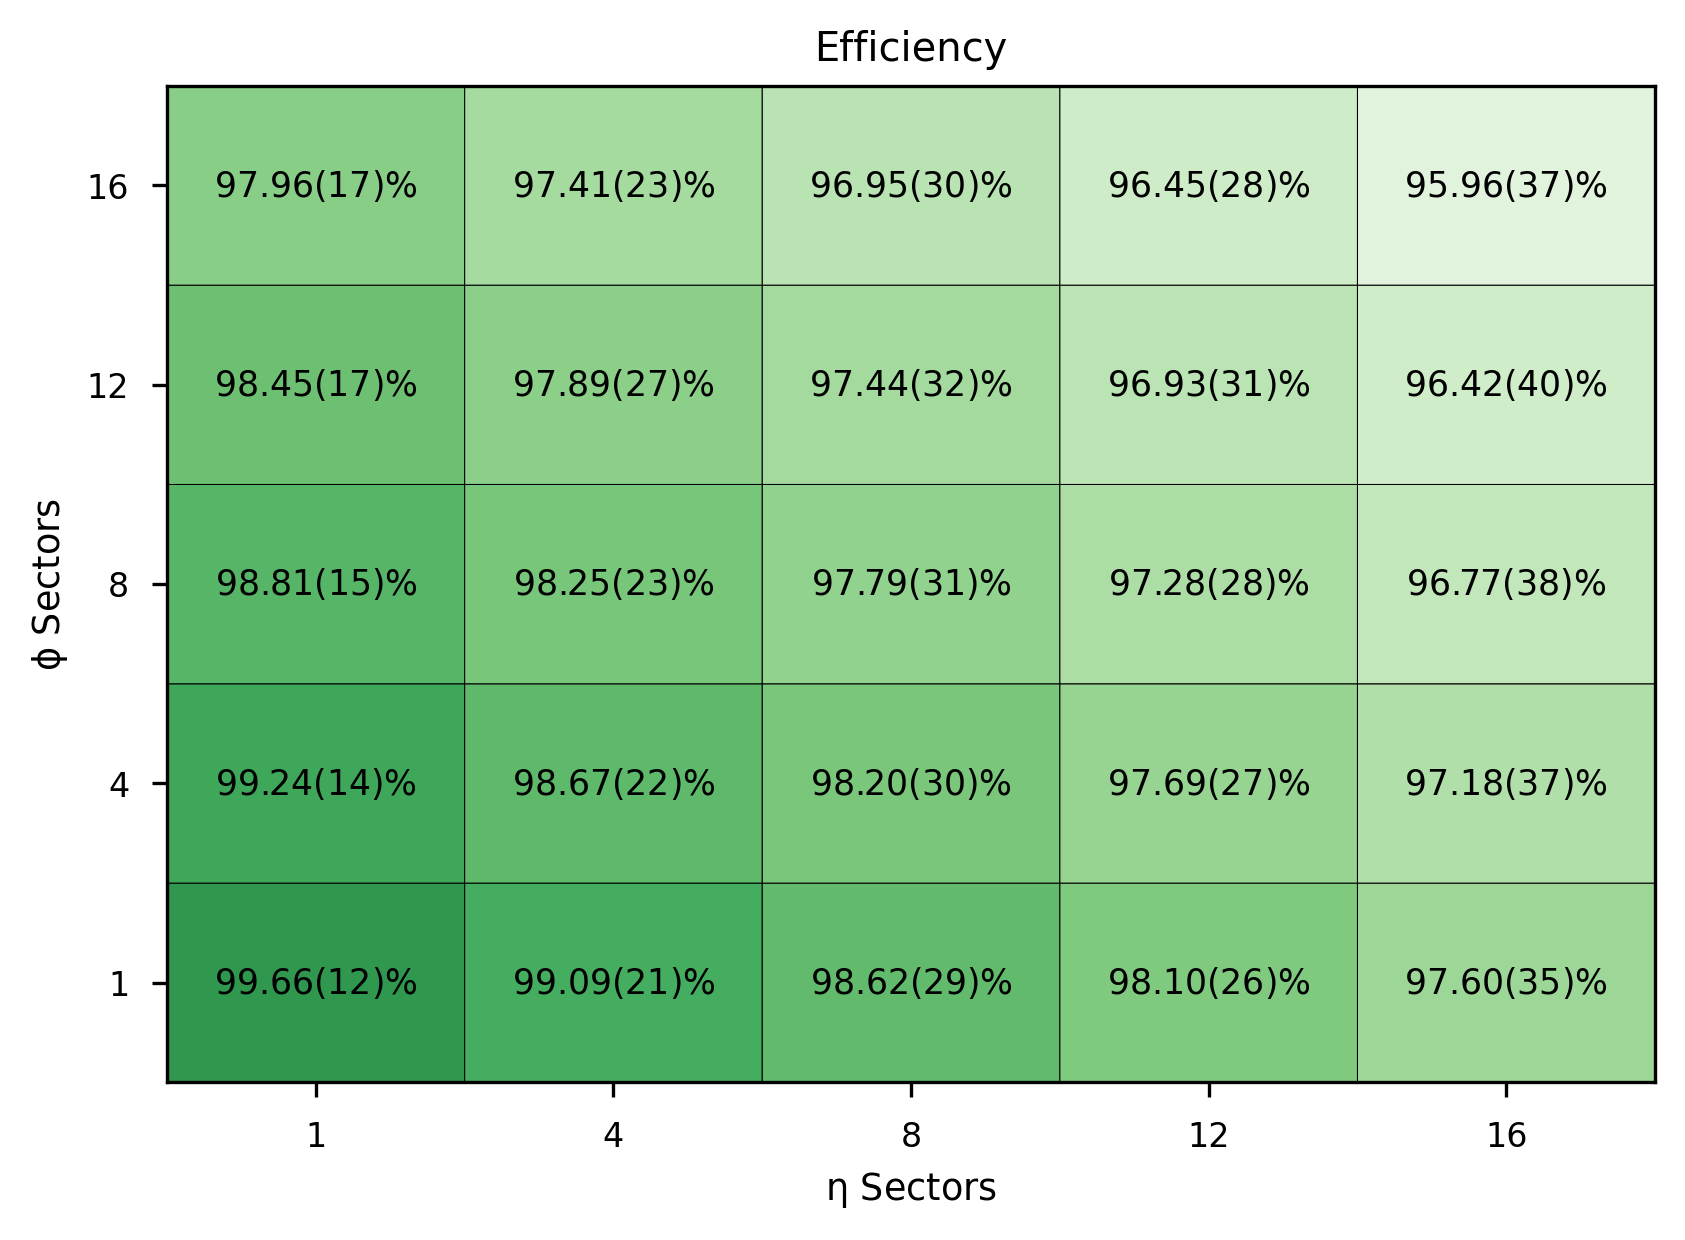

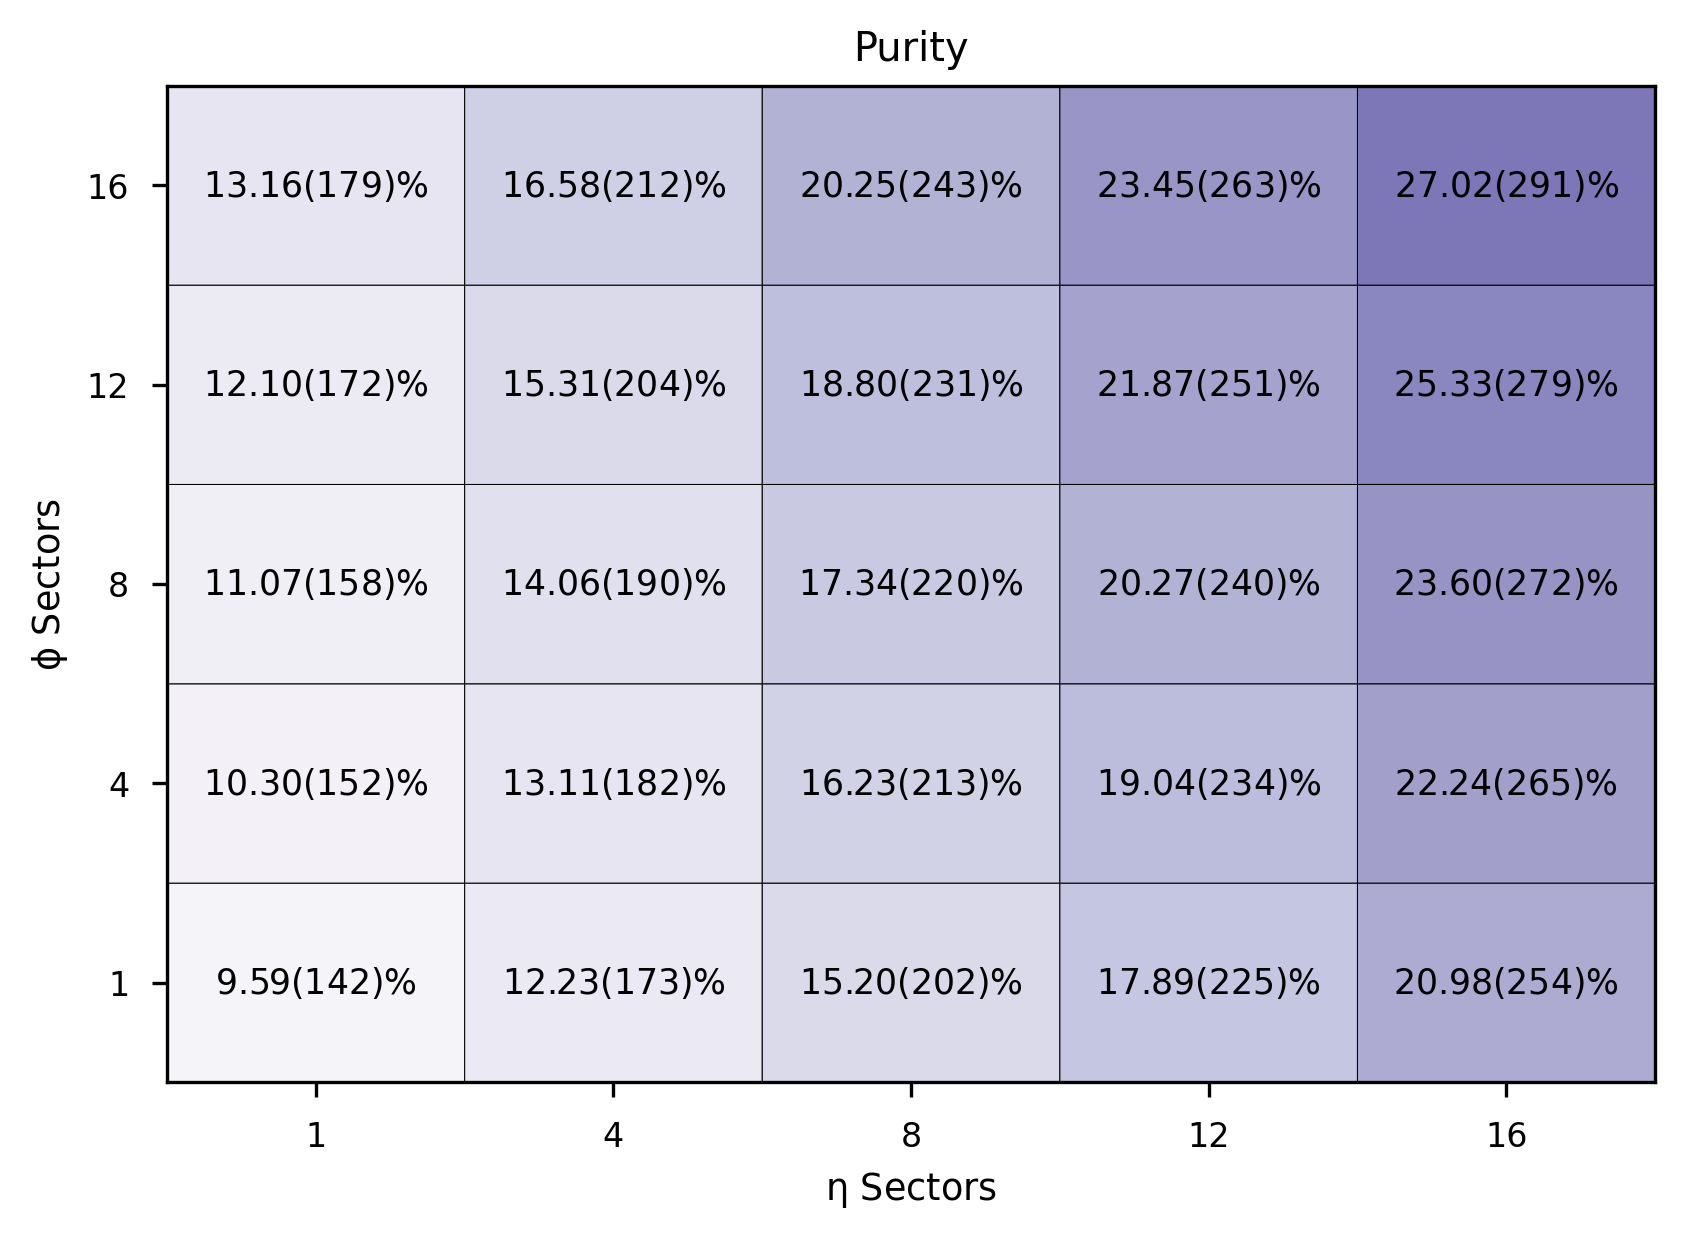

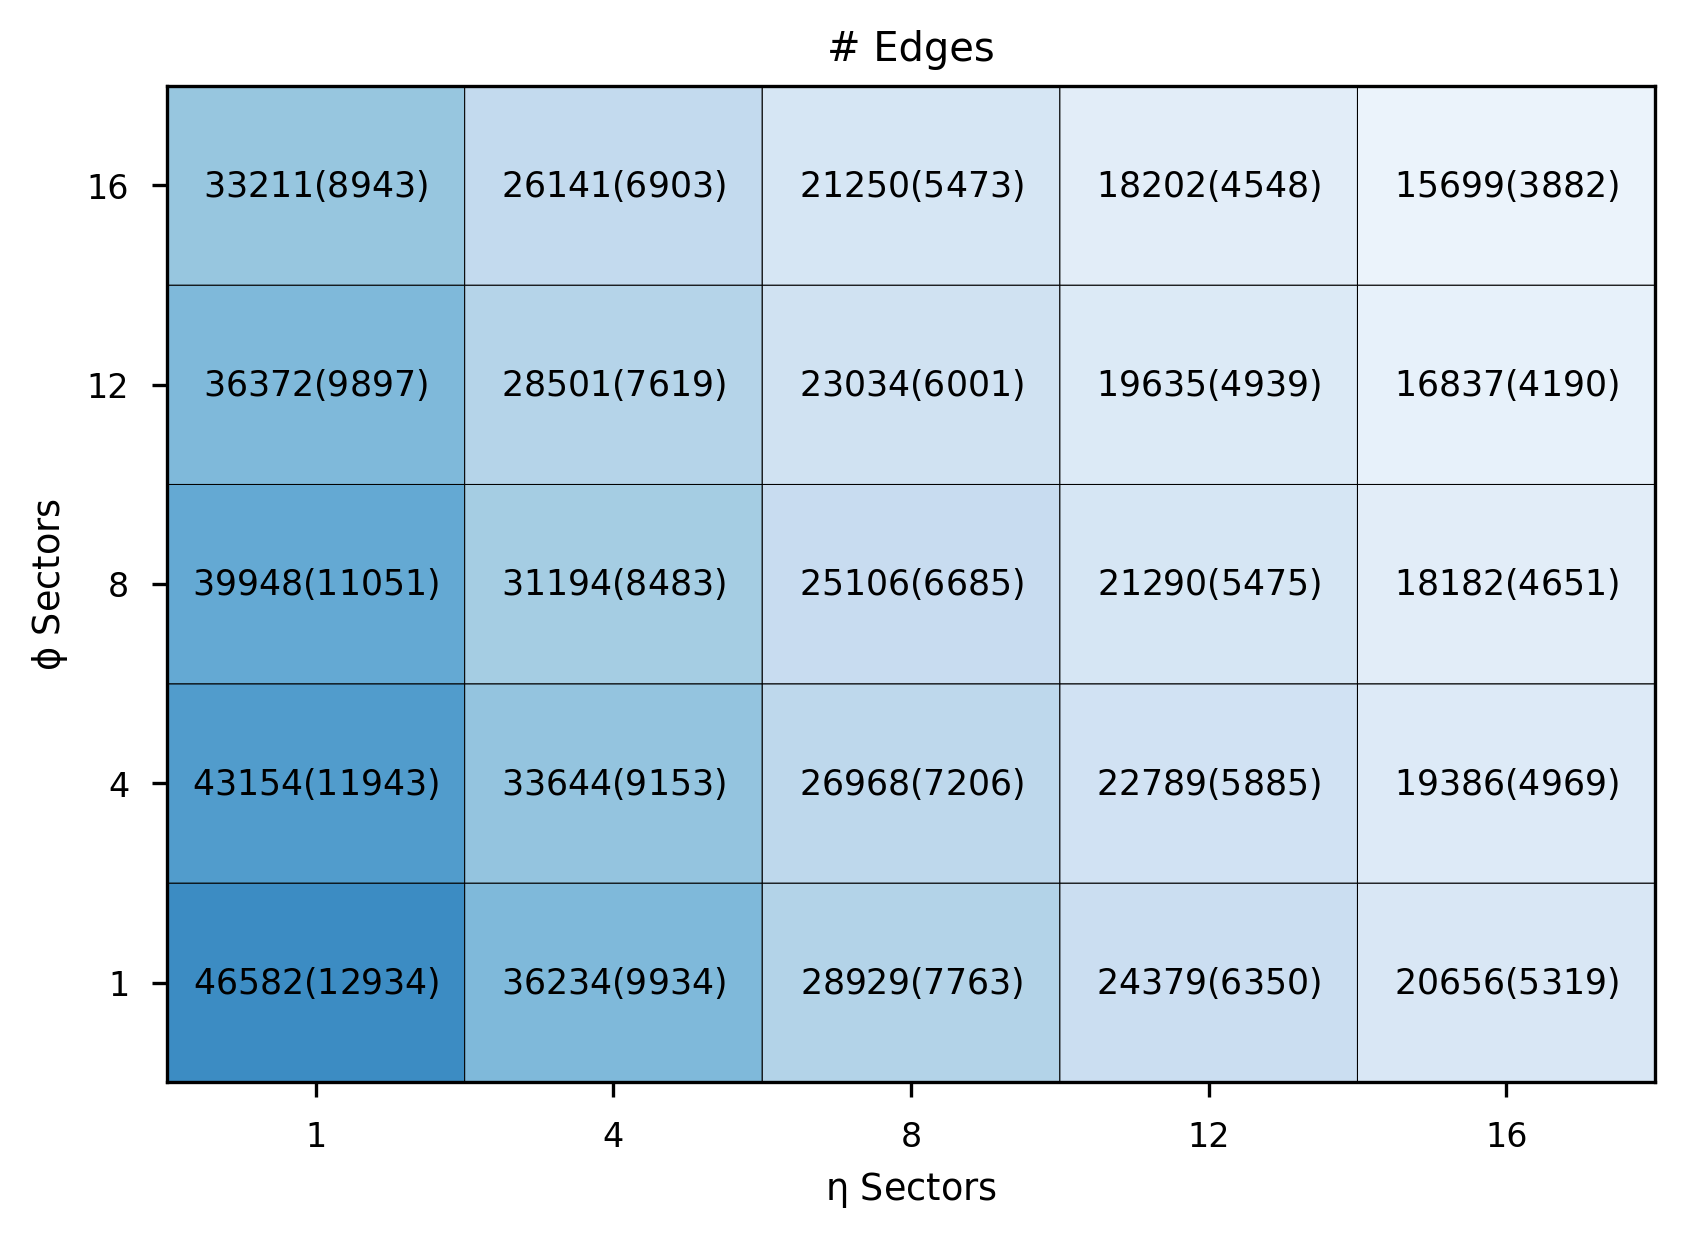

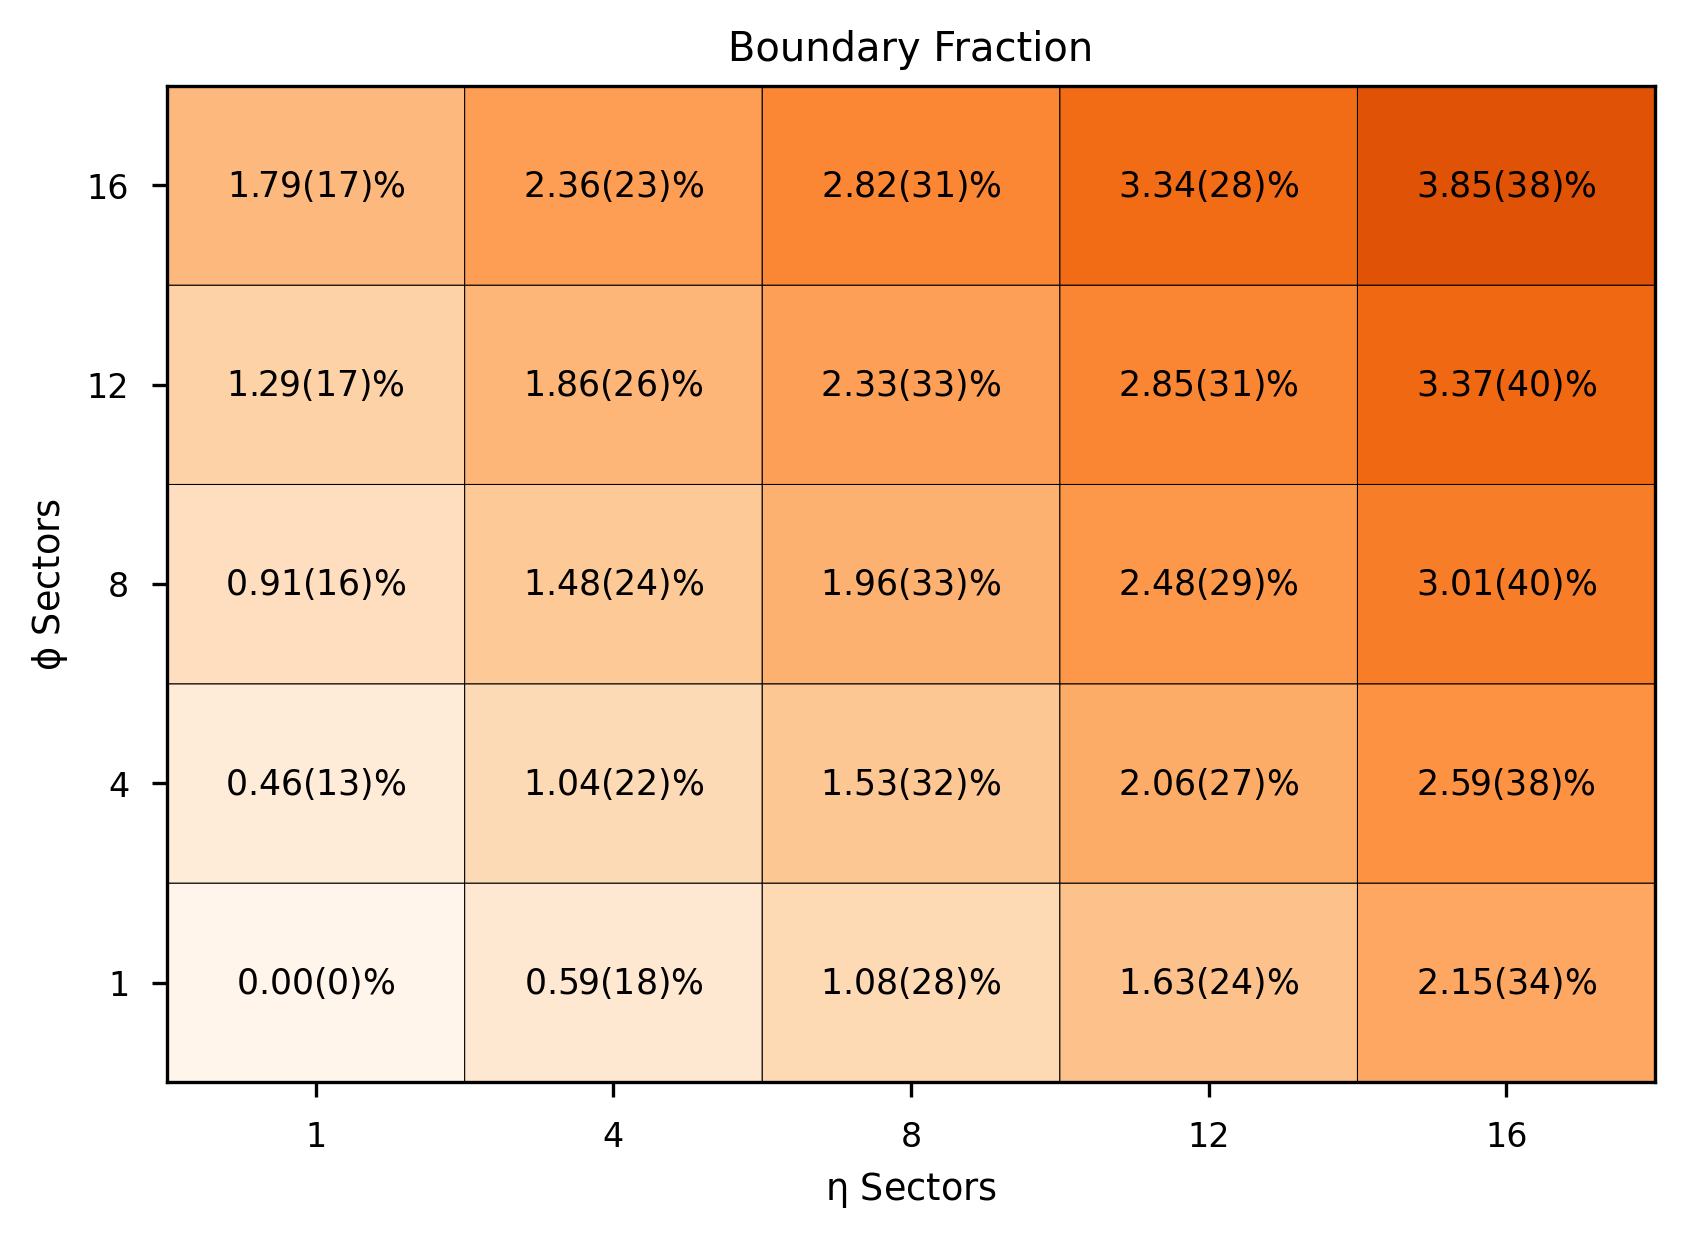

In [28]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import matplotlib.colors as mcolors
plt.rc('mathtext',**{'default':'regular'})
  
def plot_hist2d(data, data_err, label, 
                fmt='percent', cmap='Purples', v=[0.1, 0.2]):
    fig, ax = plt.subplots(dpi=300)
    heatmap = ax.pcolor(data, edgecolors='k', 
                        cmap=cmap, vmin=v[0], vmax=v[1])
    ax.set_xticks(np.array([1, 2, 3, 4, 5]) - 0.5)
    ax.set_xticklabels([1, 4, 8, 12, 16])
    ax.set_yticks(np.array([1, 2, 3, 4, 5]) - 0.5)
    ax.set_yticklabels([1, 4, 8, 12, 16])
    ax.set_xlabel('$\eta$ Sectors')
    ax.set_ylabel('$\phi$ Sectors')
    labels = np.empty(data.shape, dtype="S16")
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if (fmt=='percent'):
                labels[i,j] = '${:.2f}({})\%$'.format(100*data[i,j], int(data_err[i,j]*10**4))
            else:
                labels[i,j] = '${:d}({})$'.format(int(data[i,j]), int(data_err[i,j]))
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(x + 0.5, y + 0.5, labels[y, x].decode('ascii'),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize='smaller')
    plt.title(label)
    plt.show()

plot_hist2d(efficiencies, efficiencies_err, 'Efficiency', cmap='Greens', 
            v=[0.99*np.min(efficiencies), 1.02*np.max(efficiencies)])
plot_hist2d(purities, purities_err, 'Purity', cmap='Purples', 
            v=[0.8*np.min(purities), 1.4*np.max(purities)])
plot_hist2d(n_edges, n_edges_err, '# Edges', fmt='counts', cmap='Blues', 
            v=[0.8*np.min(n_edges), 1.4*np.max(n_edges)])
plot_hist2d(boundary_fractions, boundary_fractions_err, 'Boundary Fraction', 
            cmap='Oranges', v=[0.8*np.min(boundary_fractions), 
                               1.4*np.max(boundary_fractions)])

In [ ]:
print(n_edges, n_edges_err)
print(purities, purities_err)
print(efficiencies, efficiencies_err)

[[46582.         36234.14285714 28929.14285714 24379.61904762
  20656.61904762]
 [43154.47619048 33644.76190476 26968.23809524 22789.42857143
  19386.38095238]
 [39948.47619048 31194.04761905 25106.42857143 21290.19047619
  18182.19047619]
 [36372.76190476 28501.52380952 23034.9047619  19635.66666667
  16837.        ]
 [33211.38095238 26141.61904762 21250.38095238 18202.19047619
  15699.47619048]] [[12934.58682684  9934.77961165  7763.21230938  6350.3016312
   5319.39224488]
 [11943.20094136  9153.61051277  7206.55550708  5885.81503497
   4969.45244158]
 [11051.69948844  8483.42536095  6685.21769116  5475.79049844
   4651.74589466]
 [ 9897.71157728  7619.81743075  6001.38594235  4939.23280464
   4190.16441319]
 [ 8943.12774452  6903.83528659  5473.6576217   4548.13966803
   3882.58110784]]
[[0.09591663 0.12233298 0.1520478  0.17896338 0.20980115]
 [0.10305244 0.13107169 0.16232119 0.19044082 0.22246157]
 [0.11074281 0.1406421  0.17342071 0.20277025 0.23599805]
 [0.1210353  0.15315532 0.18798231 0.21868654 0.25335473]
 [0.13165775 0.16587028 0.2025337  0.2345556  0.27021316]] [[0.01427353 0.01733543 0.020242   0.02259846 0.02542585]
 [0.01523951 0.01829854 0.02135755 0.02343521 0.02654426]
 [0.01590568 0.01907287 0.02203539 0.02407778 0.02724467]
 [0.01726159 0.02043518 0.02313724 0.02521014 0.02792206]
 [0.01792477 0.02125695 0.02433169 0.02639789 0.02916249]]
[[0.99675493 0.99104258 0.98636495 0.98115504 0.9760925 ]
 [0.99251987 0.9868344  0.98218755 0.97703702 0.97195728]
 [0.98828561 0.98267705 0.97804247 0.97294543 0.96788725]
 [0.98466252 0.97908546 0.97451618 0.96942208 0.96438336]
 [0.9797568  0.97420812 0.96967    0.96461012 0.9597139 ]] [[0.00125261 0.00207076 0.00290442 0.00264645 0.00349725]
 [0.00142362 0.00218213 0.00300465 0.00268546 0.00370771]
 [0.00149471 0.0022803  0.00308185 0.00280431 0.00383774]
 [0.00175188 0.00267115 0.00323988 0.0031318  0.00402075]
 [0.00169625 0.0022951  0.0030095  0.00283302 0.00373857]]